# Imports

In [1]:
import pandas as pd
import os
import gc
import time 

from utils import print_evaluation_metrics, clean_database, \
    analyze_correlations, perform_voting_feature_selection, \
    log_metrics, plot_individual_metrics, print_memory_usage, explore_dataset
from preprocess import preprocessing
pd.set_option('display.max_columns', None)
preprocessing_output_dir = os.path.join('data', 'figures', '5G NIDD', 'preprocessing')
db_path = os.path.join('data', 'datasets', '5G NIDD', 'Combined.csv')

# Data cleaning and splitting

Original shape: (1215890, 52)
Shape after removing duplicates: (1215889, 52)

[Verification] Class distribution (normalized) across splits:
                Original     Train       Val      Test
Attack Type                                           
Benign          0.392911  0.392774  0.393670  0.393243
HTTPFlood       0.115810  0.115733  0.115183  0.117050
ICMPFlood       0.000950  0.000963  0.000855  0.000938
SYNFlood        0.007995  0.007936  0.008290  0.008175
SYNScan         0.016484  0.016526  0.016515  0.016120
SlowrateDoS     0.060140  0.060225  0.059117  0.060482
TCPConnectScan  0.016492  0.016588  0.016219  0.015997
UDPFlood        0.376136  0.376238  0.376679  0.374779
UDPScan         0.013082  0.013016  0.013472  0.013217
Saved distribution plot to data/figures/5G NIDD/preprocessing/class_distribution_check.png


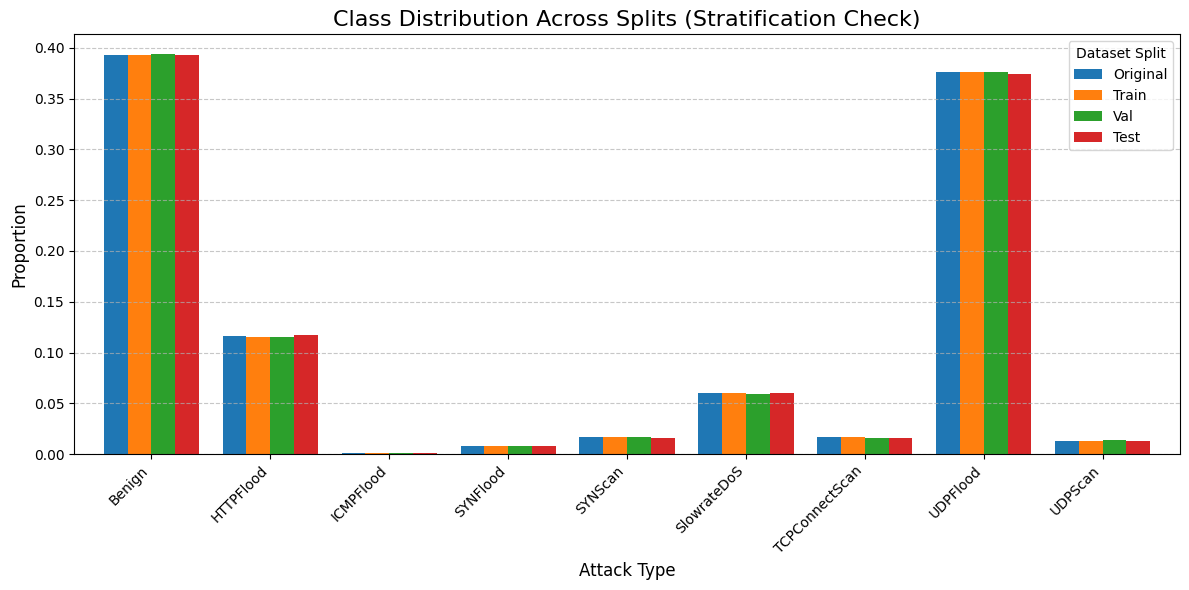

[Memory] Before GC: 1548.39 MB
[Memory] After GC: 1400.73 MB
[Preprocessing] Applying PowerTransformer (Yeo-Johnson) to fix skewness and standardize data...
[Visualization] Plotting top 3 skewed features before transformation: ['DstGap', 'SrcGap', 'DstRate']


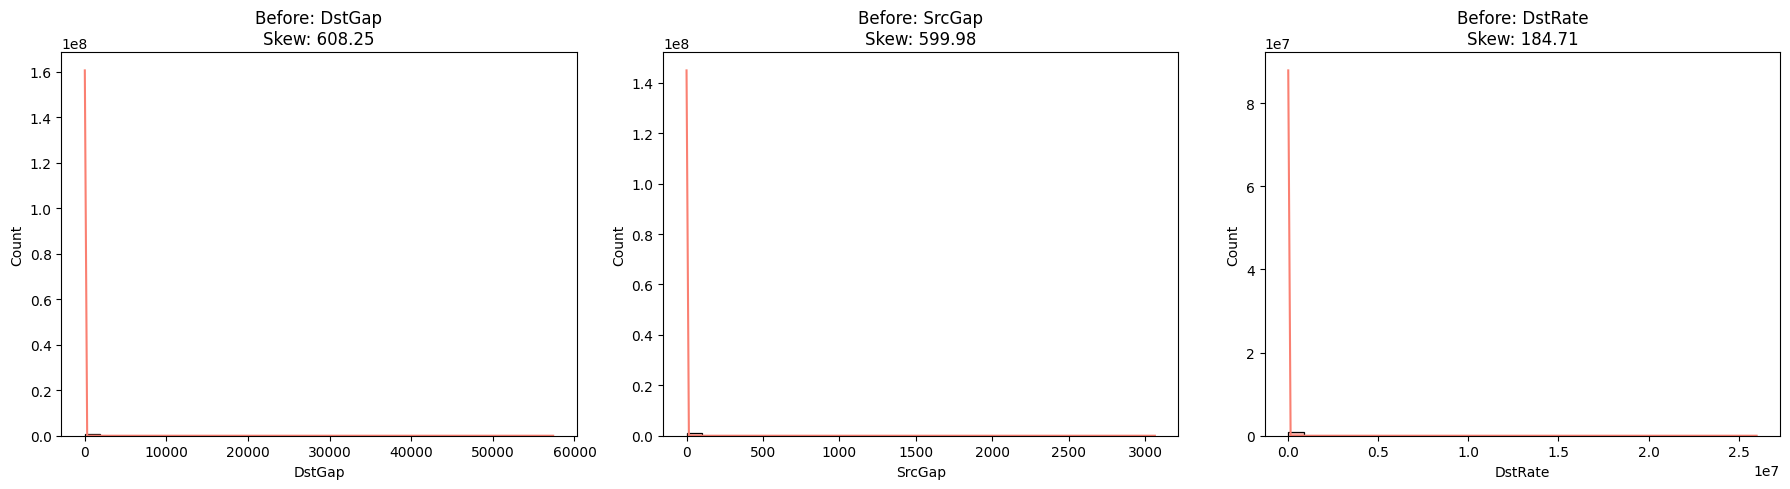

[Visualization] Plotting top 3 skewed features after transformation


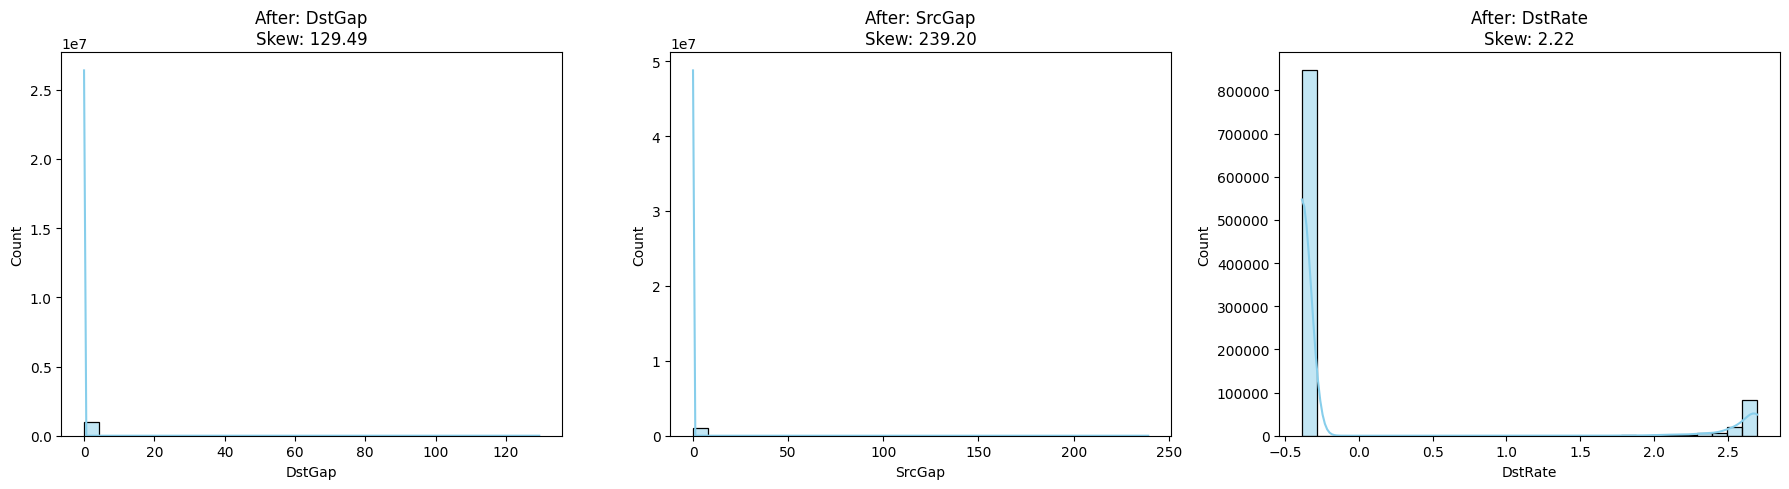

<class 'pandas.core.frame.DataFrame'>
Index: 972711 entries, 528336 to 737081
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dur         972711 non-null  float32
 1   Mean        972711 non-null  float32
 2   Sum         972711 non-null  float32
 3   Min         972711 non-null  float32
 4   Max         972711 non-null  float32
 5   Proto       972711 non-null  float32
 6   sTos        972711 non-null  float32
 7   dTos        972711 non-null  float32
 8   sDSb        972711 non-null  float32
 9   dDSb        972711 non-null  float32
 10  sTtl        972711 non-null  float32
 11  dTtl        972711 non-null  float32
 12  Cause       972711 non-null  float32
 13  TotPkts     972711 non-null  float32
 14  SrcPkts     972711 non-null  float32
 15  DstPkts     972711 non-null  float32
 16  TotBytes    972711 non-null  float32
 17  SrcBytes    972711 non-null  float32
 18  DstBytes    972711 non-null  float32
 19  Of

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test, output_encoder = clean_database(db_path, preprocessing_output_dir, do_scale=False, fix_skewness=True)
# Force garbage collection to clear the large raw dataframe from memory immediately
gc.collect()
print_memory_usage("Notebook - After clean_database")

# Explore The Dataset


Training Data Analysis
Shape: (972711, 40)
Feature Types:
float32    40
Name: count, dtype: int64

[Missing Values] None found (Clean).

[Numerical Features] Summary of 40 features:
  - High Skewness detected in 22 features (e.g., SrcGap: 239.20)


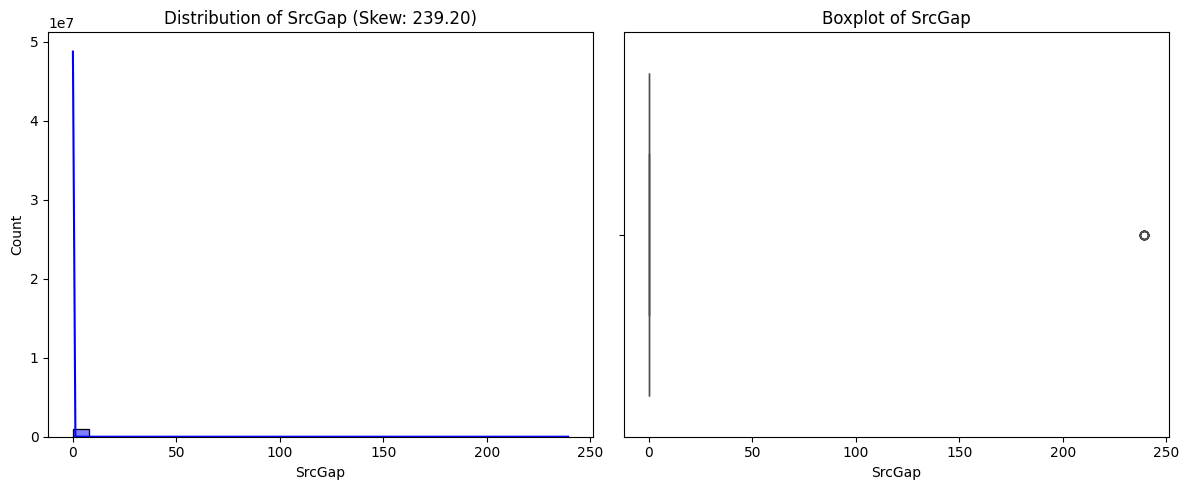

  - Value Range: -18.01 to 239.20


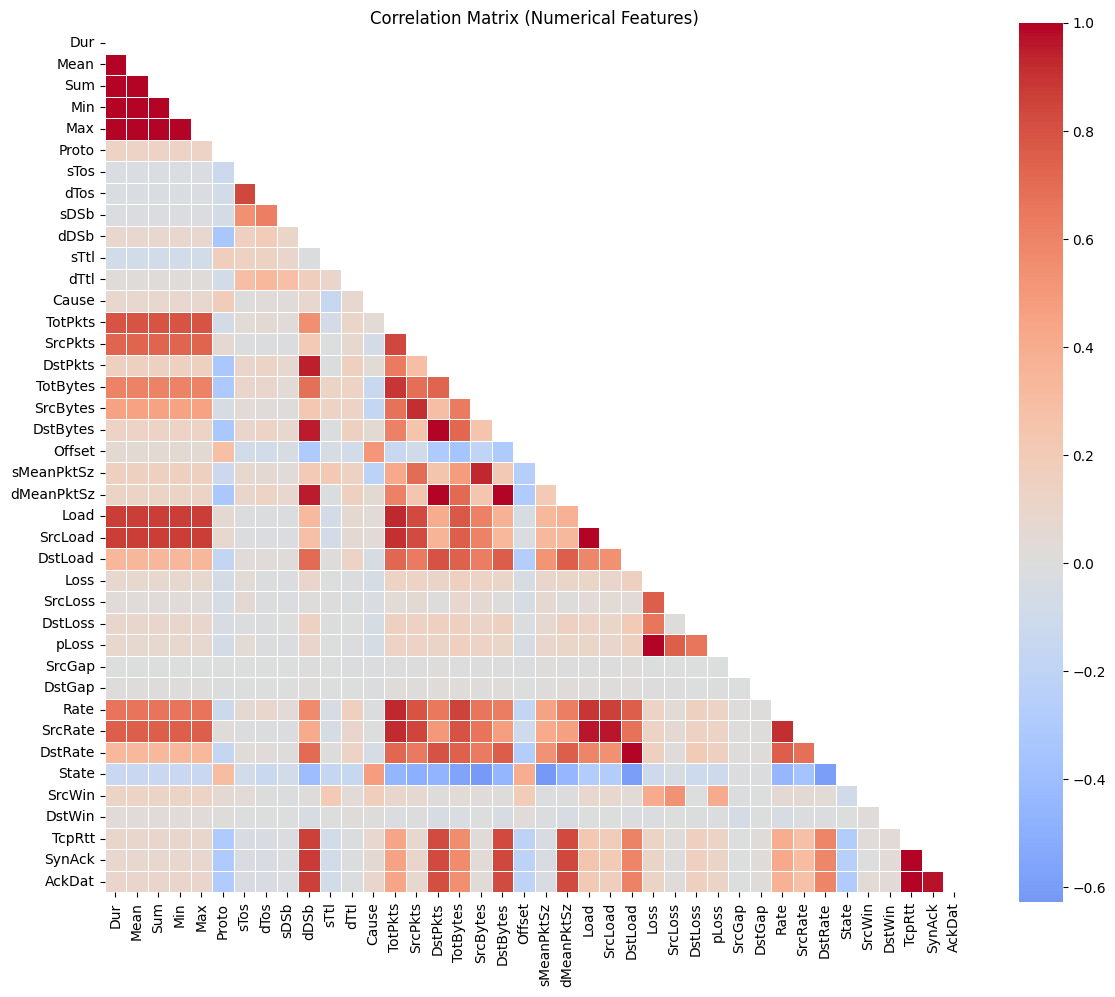


[Target Variable]
0    0.392774
7    0.376238
1    0.115733
5    0.060225
6    0.016588
4    0.016526
8    0.013016
3    0.007936
2    0.000963
Name: proportion, dtype: float64


/Users/hemaali/Desktop/Master Degree Project/utils.py:186: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_series, palette='Set2')


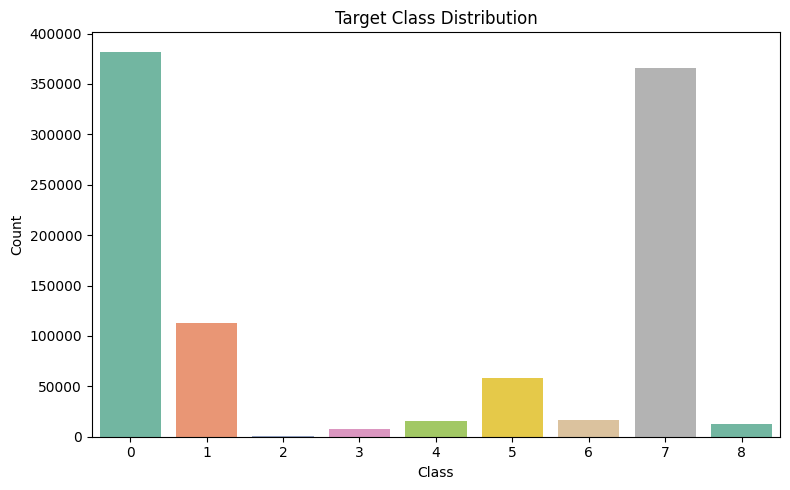


SUMMARY OF ADVICE
1. Skewness: Consider Log-transformation or PowerTransformer (Yeo-Johnson) for highly skewed features.
2. Class Imbalance: Severe imbalance detected (<5%). Use SMOTE, ADASYN, or Class Weights.



In [3]:
explore_dataset(X_train, y_train, title="Training Data Analysis")


# Feature Selection

## Correlations

### Analyze correlation between featrues

[Memory] Notebook - Before Correlation Analysis: 1904.06 MB


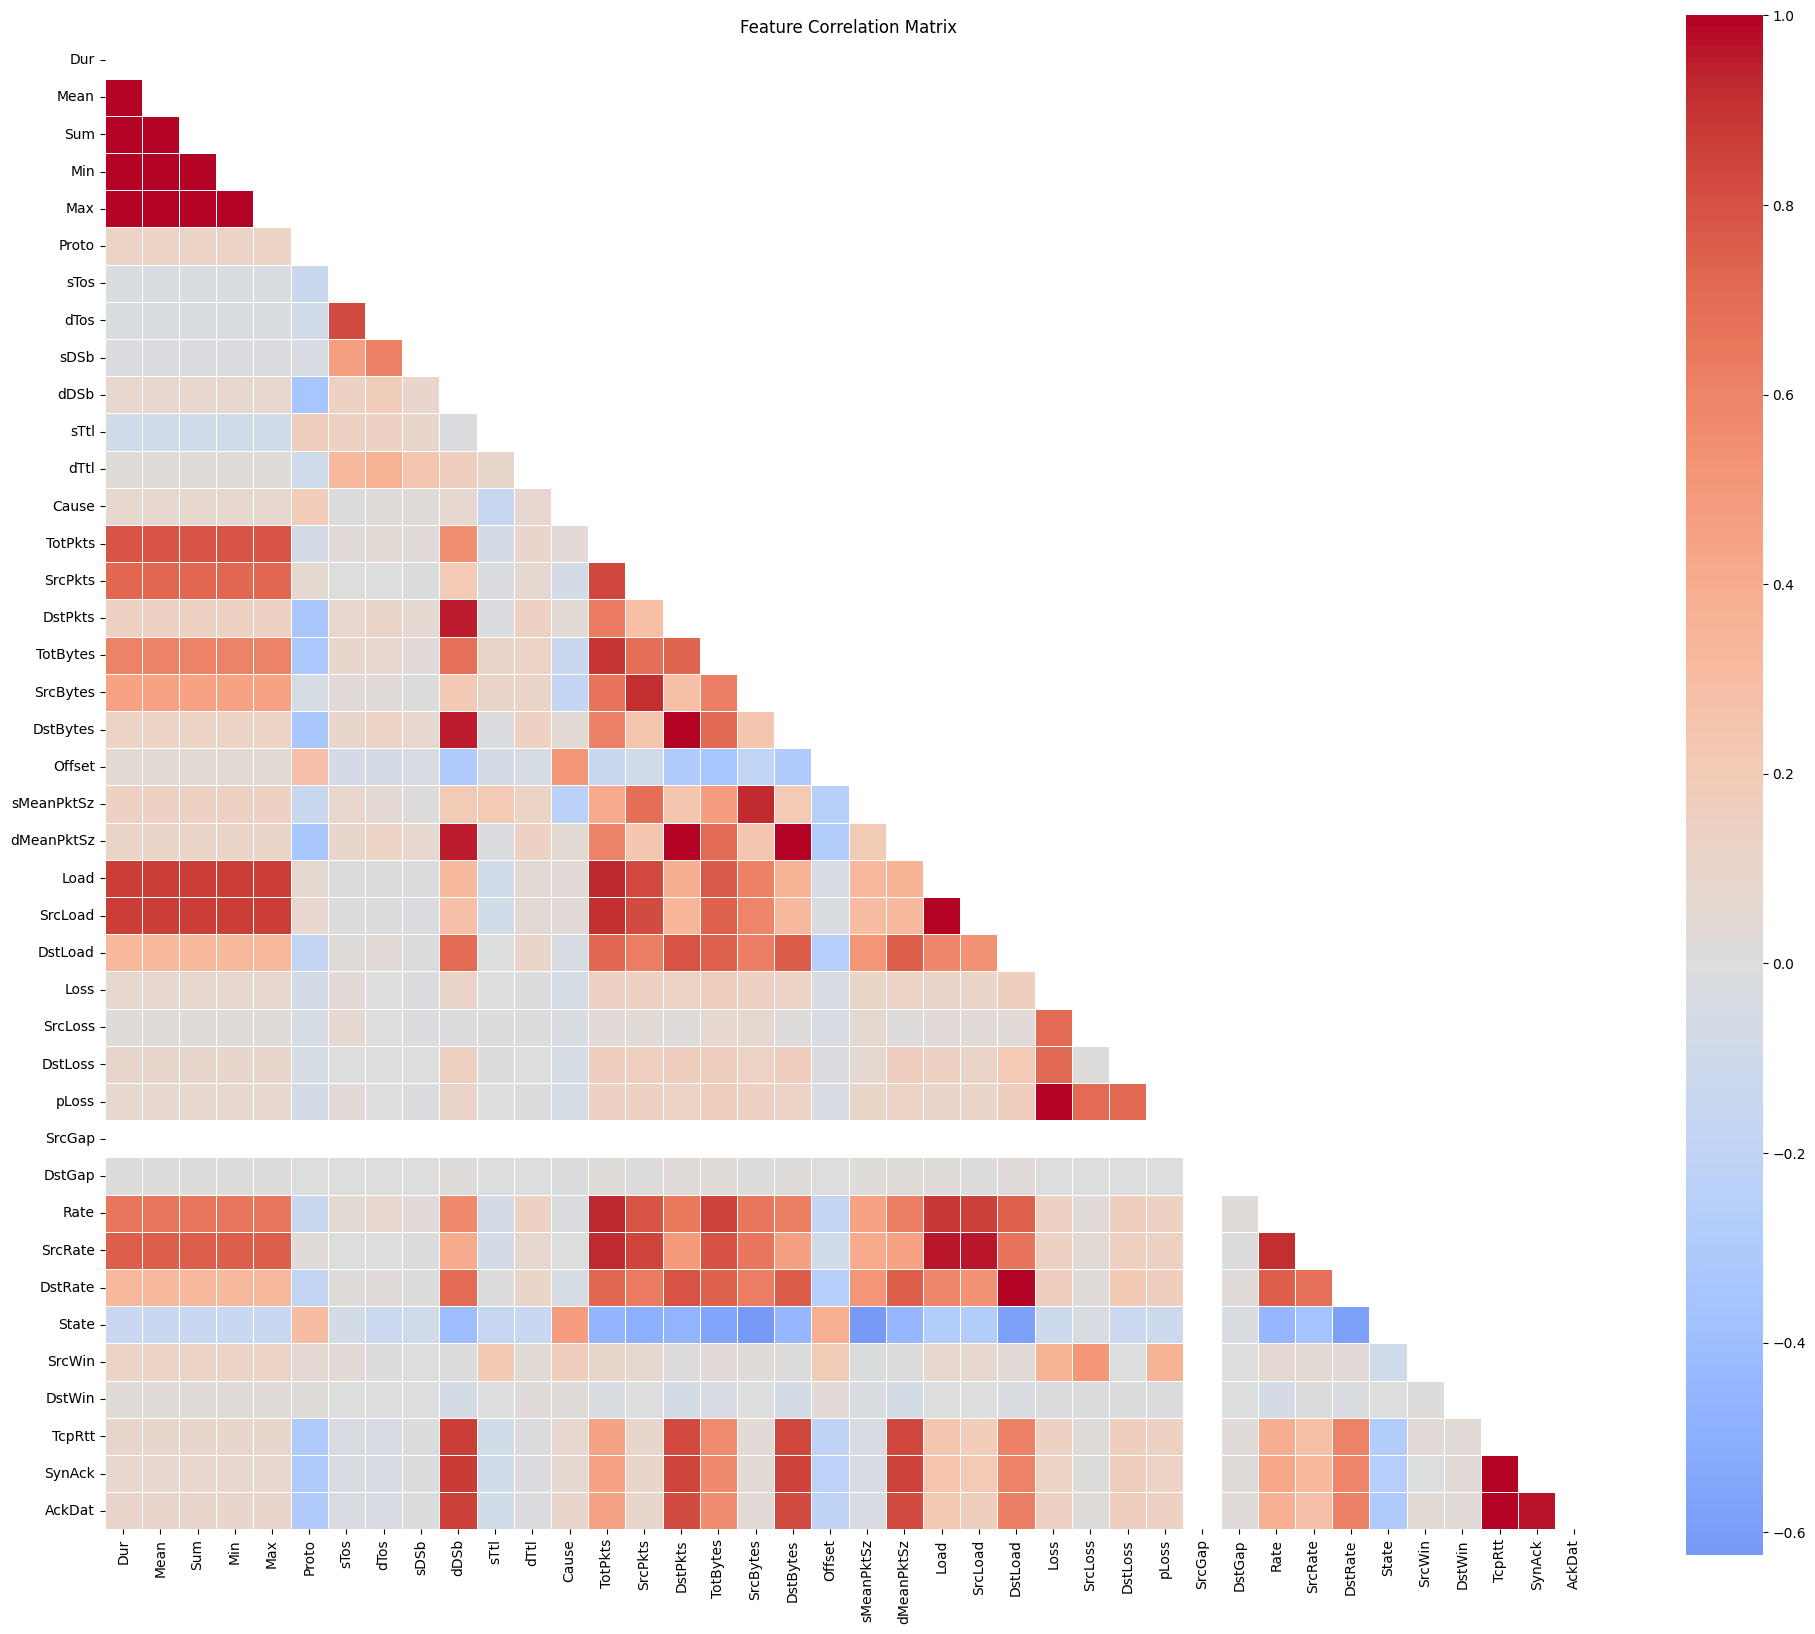


[Analysis] Features with correlation > 0.95:
  - Mean is correlated with ['Dur']
  - Sum is correlated with ['Dur', 'Mean']
  - Min is correlated with ['Dur', 'Mean', 'Sum']
  - Max is correlated with ['Dur', 'Mean', 'Sum', 'Min']
  - DstPkts is correlated with ['dDSb']
  - DstBytes is correlated with ['dDSb', 'DstPkts']
  - dMeanPktSz is correlated with ['dDSb', 'DstPkts', 'DstBytes']
  - SrcLoad is correlated with ['Load']
  - pLoss is correlated with ['Loss']
  - SrcRate is correlated with ['Load', 'SrcLoad']
  - DstRate is correlated with ['DstLoad']
  - SynAck is correlated with ['TcpRtt']
  - AckDat is correlated with ['TcpRtt', 'SynAck']
[Memory] Notebook - After Correlation Analysis: 1871.52 MB


In [4]:
print_memory_usage("Notebook - Before Correlation Analysis")

# Optimization: If X_train is very large (>50k rows), calculating correlation on the full dataset is slow 
# and unnecessary. A random sample of 50k rows provides a statistically accurate correlation matrix.
if len(X_train) > 50000:
    high_corr_features = analyze_correlations(X_train.sample(50000, random_state=42), threshold=0.95)
else:
    high_corr_features = analyze_correlations(X_train, threshold=0.95)

print_memory_usage("Notebook - After Correlation Analysis")

### Drop correlated featuers

In [5]:
# Use inplace=True to avoid creating a copy of the dataframe in memory
X_train.drop(columns=high_corr_features, inplace=True)
X_val.drop(columns=high_corr_features, inplace=True)
X_test.drop(columns=high_corr_features, inplace=True)
print(f"Dropped {len(high_corr_features)} correlated features.")
gc.collect()
print_memory_usage("Notebook - After Dropping Correlated Features")

Dropped 13 correlated features.
[Memory] Notebook - After Dropping Correlated Features: 1858.45 MB


## Arguments

In [8]:
version = 'v1'
sampling_method = 'smote'
plot_distributions = True
model_results= []
preprocessing_args_list = [X_train, X_val, X_test, y_train, y_val, y_test, output_encoder, preprocessing_output_dir, version, sampling_method, plot_distributions]

## Compare the results of all methods

[Memory] Notebook - Before Feature Selection: 1456.44 MB

[Comparison] Downsampling training data to 50000 samples for feature selection...

Comparing Feature Selection Methods

--- Filter Method: pearson ---

[Filter] Starting PEARSON Feature Selection to select top 20 features...
[Filter] Completed in 0.00 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'sTos', 'dTos', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'SrcPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9795

--- Filter Method: anova ---

[Filter] Starting ANOVA Feature Selection to select top 20 features...
[Filter] Completed in 0.00 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'DstLoss', 'Rate', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9795

--- Filter Method: chi2 ---

[F

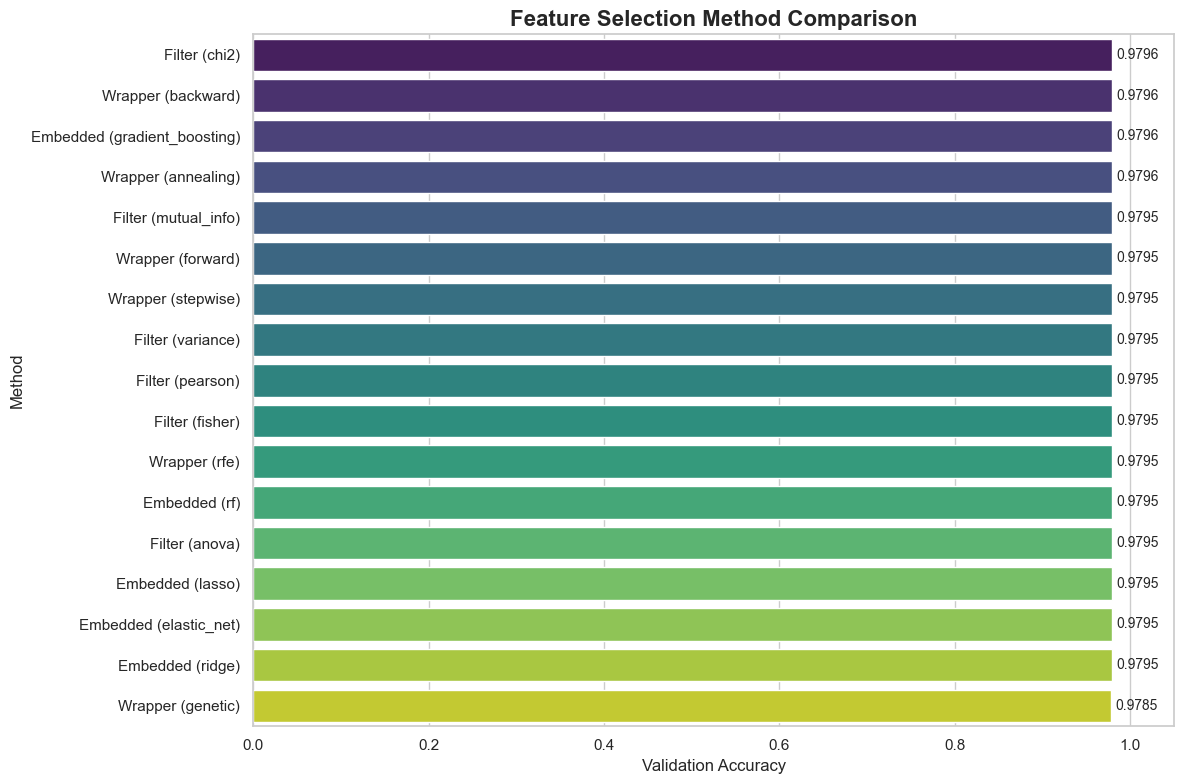


Starting Voting Feature Selection (Top 3 Methods)
Top 3 methods selected for voting:
  - Filter (chi2) (Accuracy: 0.9796)
  - Wrapper (backward) (Accuracy: 0.9796)
  - Embedded (gradient_boosting) (Accuracy: 0.9796)

[Voting] Features selected by majority (2+ votes): ['Dur', 'Proto', 'sTos', 'dTos', 'dDSb', 'sTtl', 'Cause', 'SrcPkts', 'TotBytes', 'Offset', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'Rate', 'State', 'SrcWin', 'TcpRtt', 'sDSb', 'sMeanPktSz', 'DstWin']
[Voting] Total features selected: 22
[Memory] Notebook - After Feature Selection: 2049.98 MB


In [9]:
print_memory_usage("Notebook - Before Feature Selection")

# Optimization: 'sample_size=50000' significantly speeds up Wrapper methods (like RFE) 
# which are extremely slow on the full dataset (200k+ rows).
selected_features, comparison_results = perform_voting_feature_selection(
    X_train, y_train, X_val, y_val, 
    n_features=20, 
    sample_size=50000,  # <--- Performance Fix
    top_k=3,
    file_path=preprocessing_output_dir,
    version=version
)
gc.collect()
print_memory_usage("Notebook - After Feature Selection")

# LDA
# X_train, X_val, X_test = perform_lda_reduction(X_train, y_train, X_val, X_test)

# Autoencoder
# X_train, X_val, X_test = perform_autoencoder_reduction(
#     X_train, X_val, X_test, 
#     encoding_dim=20, 
#     epochs=20, 
#     device=device
# )

## Filter the dataframes to include only selected columns

In [9]:
# Overwrite your dataframes to keep ONLY the selected columns
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

gc.collect()

preprocessing_args_list = [X_train, X_val, X_test, y_train, y_val, y_test, output_encoder, preprocessing_output_dir, version]

# Preprocessing

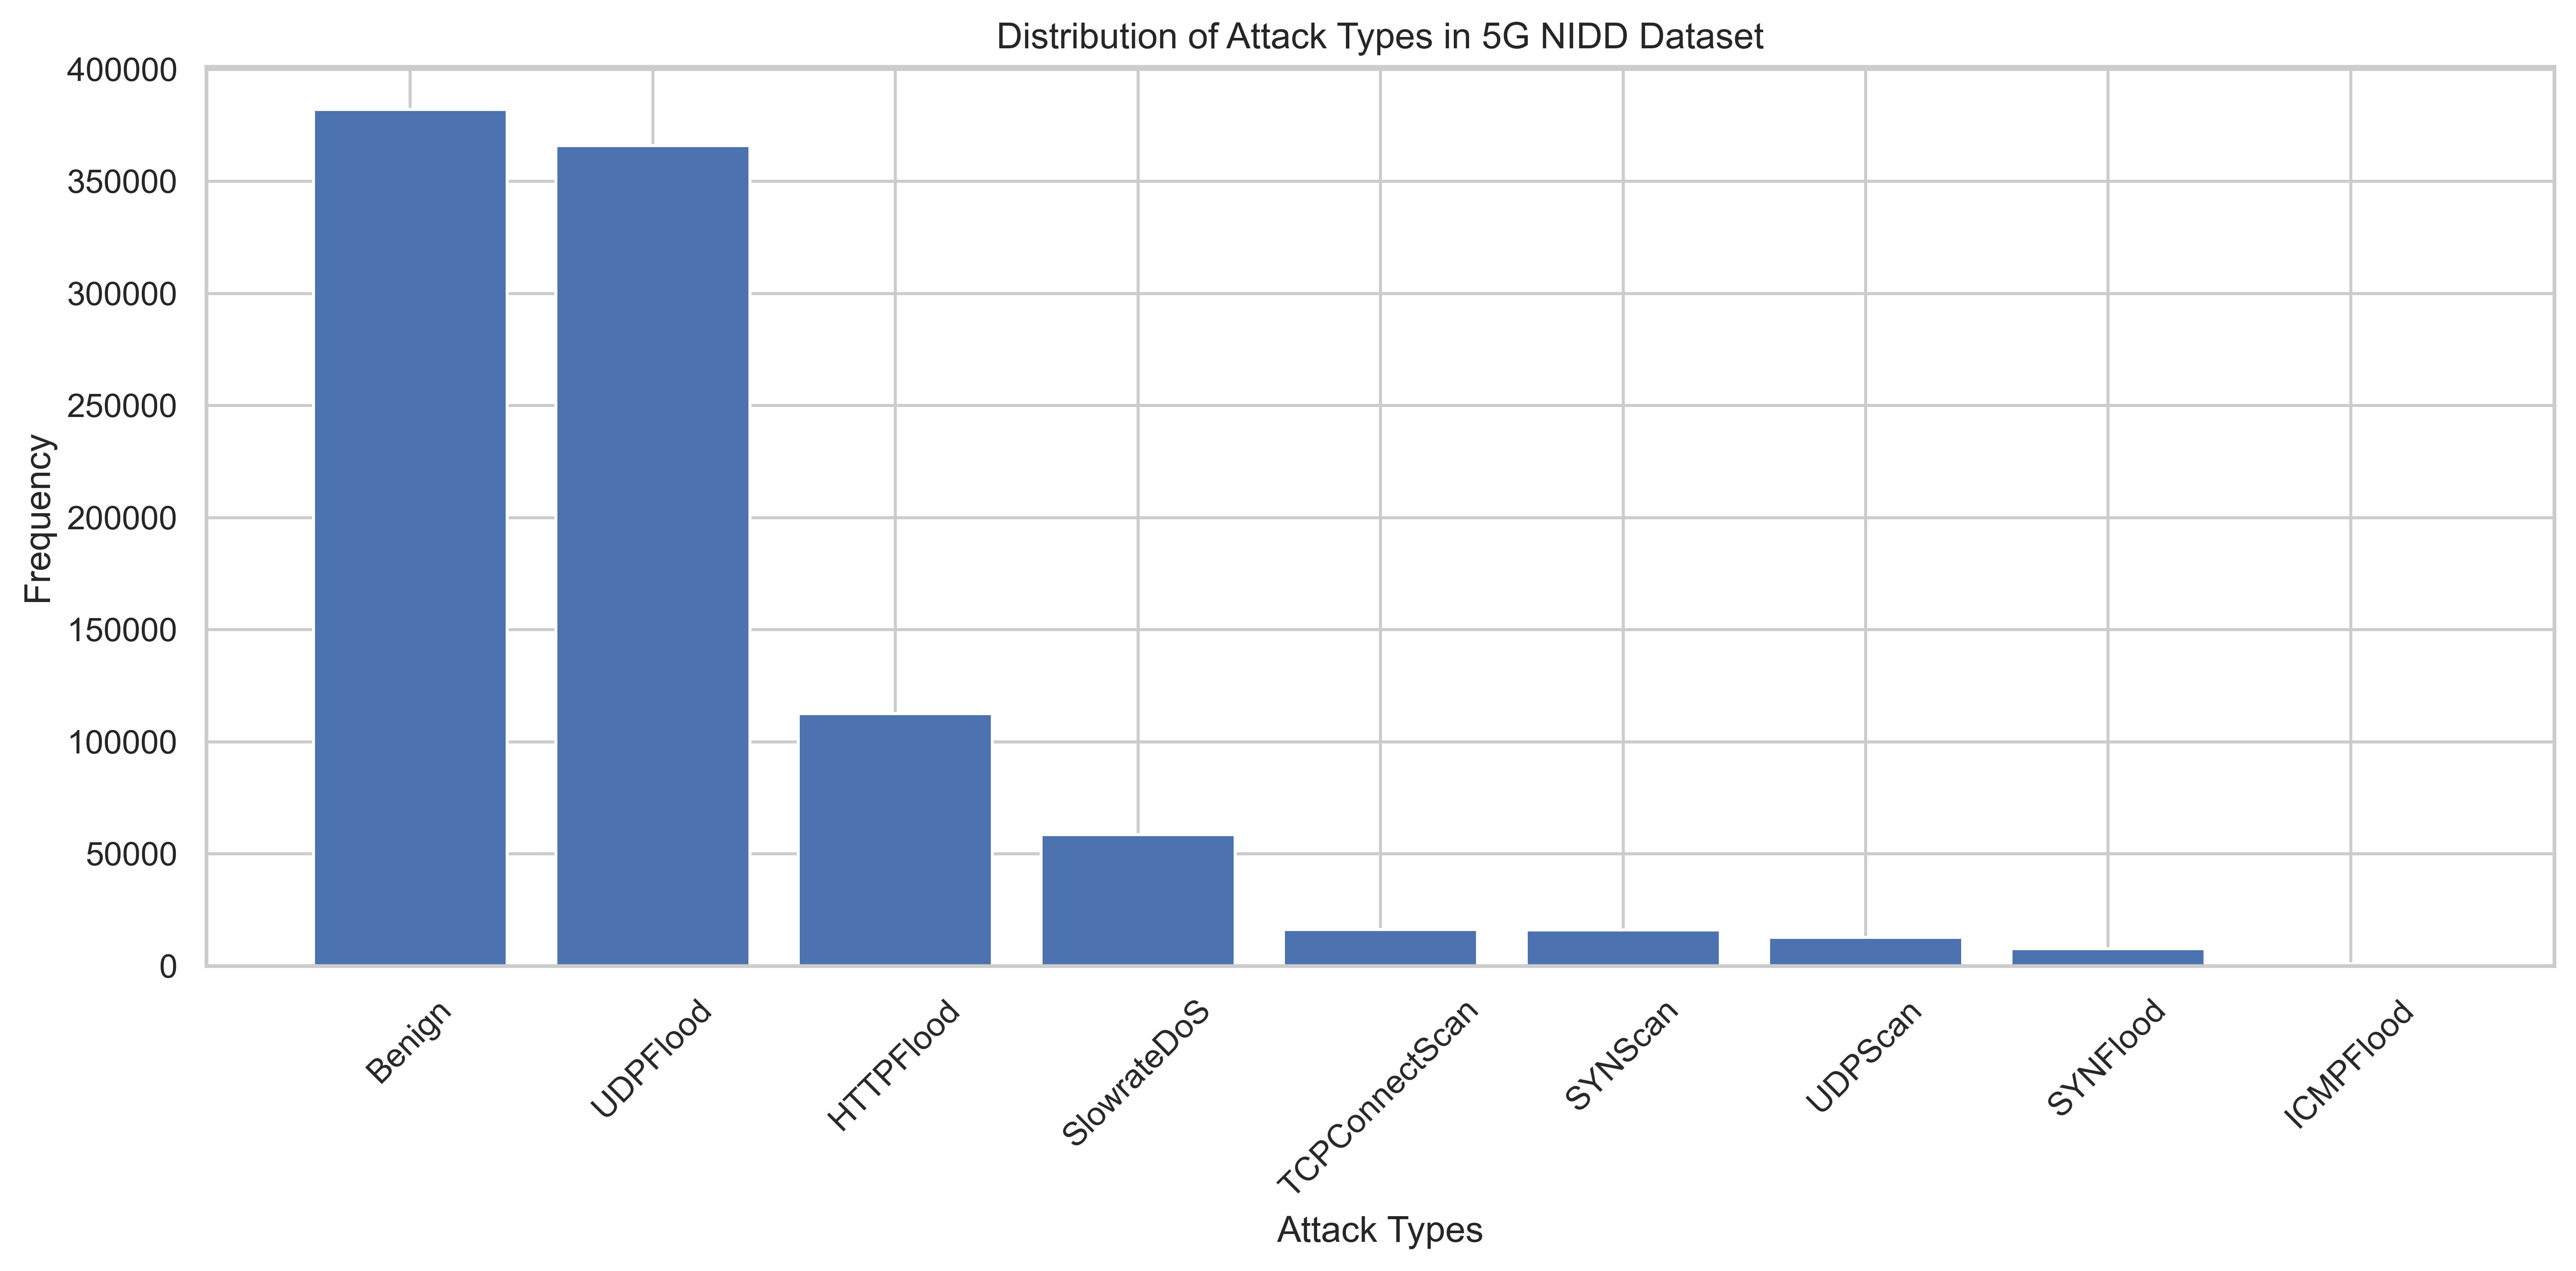

[Memory] Before Sampling (smote): 1993.67 MB
[Memory] After Sampling (smote): 2060.23 MB


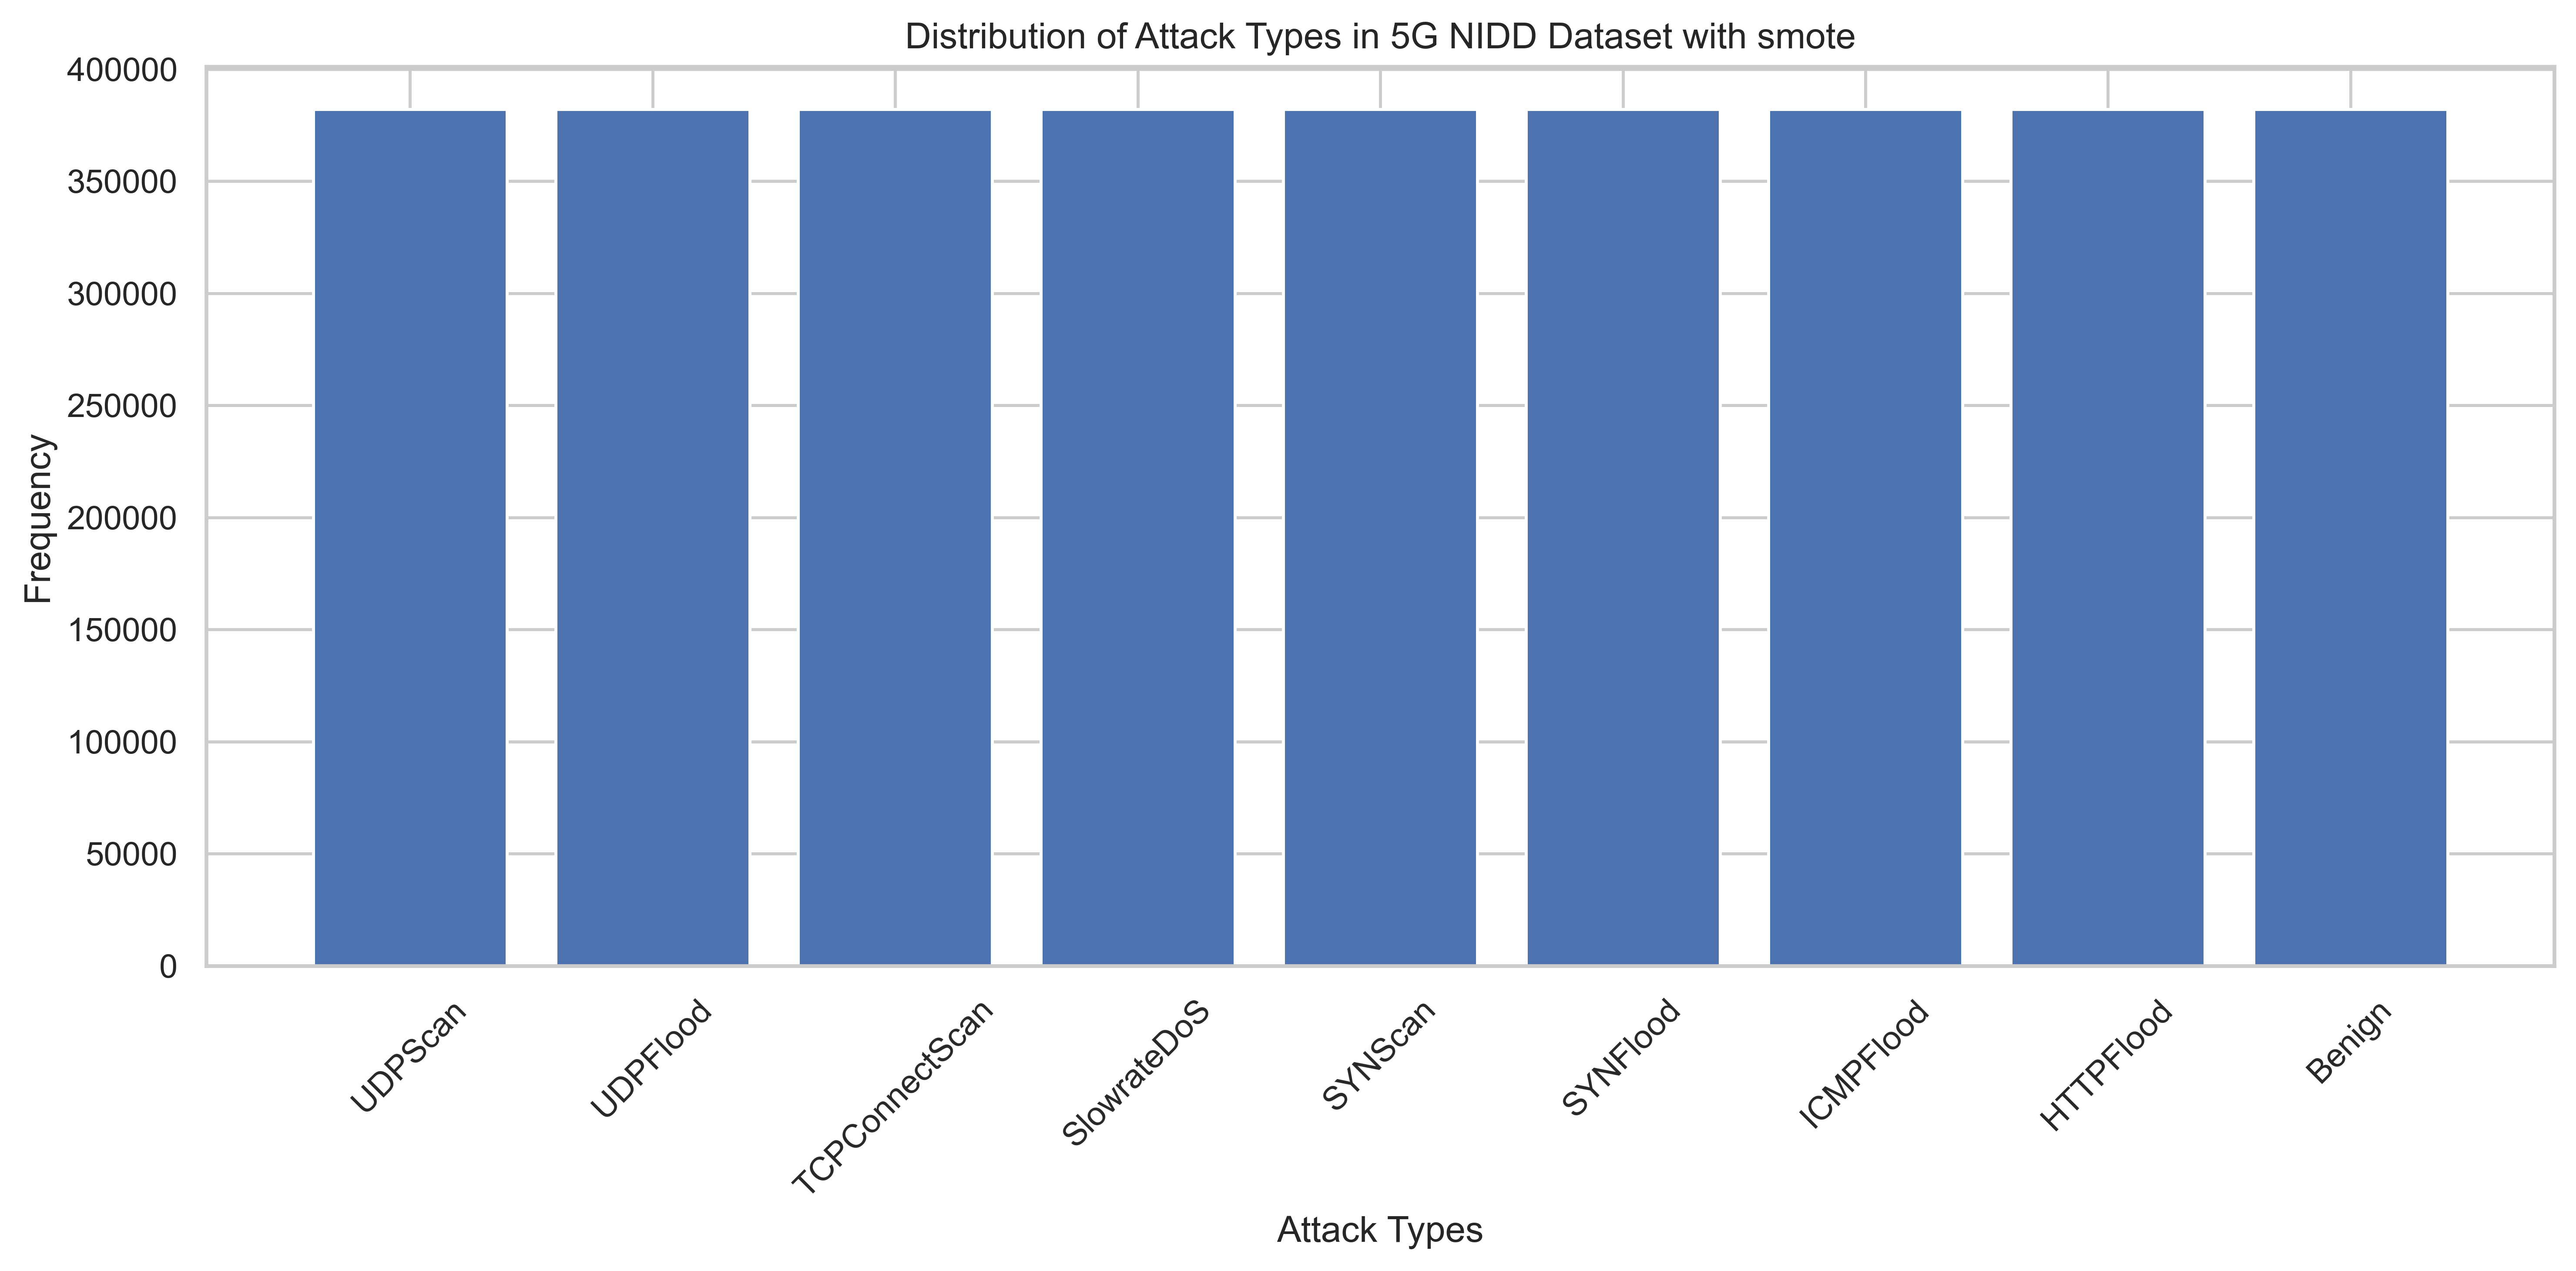

[Memory] Notebook - Ready for Training: 1853.00 MB


In [10]:
X_train_processed, X_val_scaled, X_test_scaled, y_resampled, y_val, y_test = preprocessing(*preprocessing_args_list)
print_memory_usage("Notebook - Ready for Training")


# Machine Learning

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB


## Logistic Regression

In [12]:
linear_model = LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1, random_state=42)

start_time = time.time()
linear_model.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

start_time = time.time()
y_pred_lr = linear_model.predict(X_val_scaled)
prediction_time = time.time() - start_time


Logistic Regression Evaluation:
Accuracy: 0.9420
Precision: 0.9445
Recall: 0.9420
F1 Score: 0.9428
Training Time: 40.9738 seconds
Prediction Time: 0.0045 seconds
latency per sample: 0.000000 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign       0.95      0.94      0.95     47866
     HTTPFlood       0.94      0.91      0.93     14005
     ICMPFlood       0.30      1.00      0.47       104
      SYNFlood       0.98      1.00      0.99      1008
       SYNScan       1.00      1.00      1.00      2008
   SlowrateDoS       0.80      0.91      0.85      7188
TCPConnectScan       0.94      1.00      0.97      1972
      UDPFlood       0.96      0.95      0.95     45800
       UDPScan       0.98      1.00      0.99      1638

      accuracy                           0.94    121589
     macro avg       0.87      0.97      0.90    121589
  weighted avg       0.94      0.94      0.94    121589



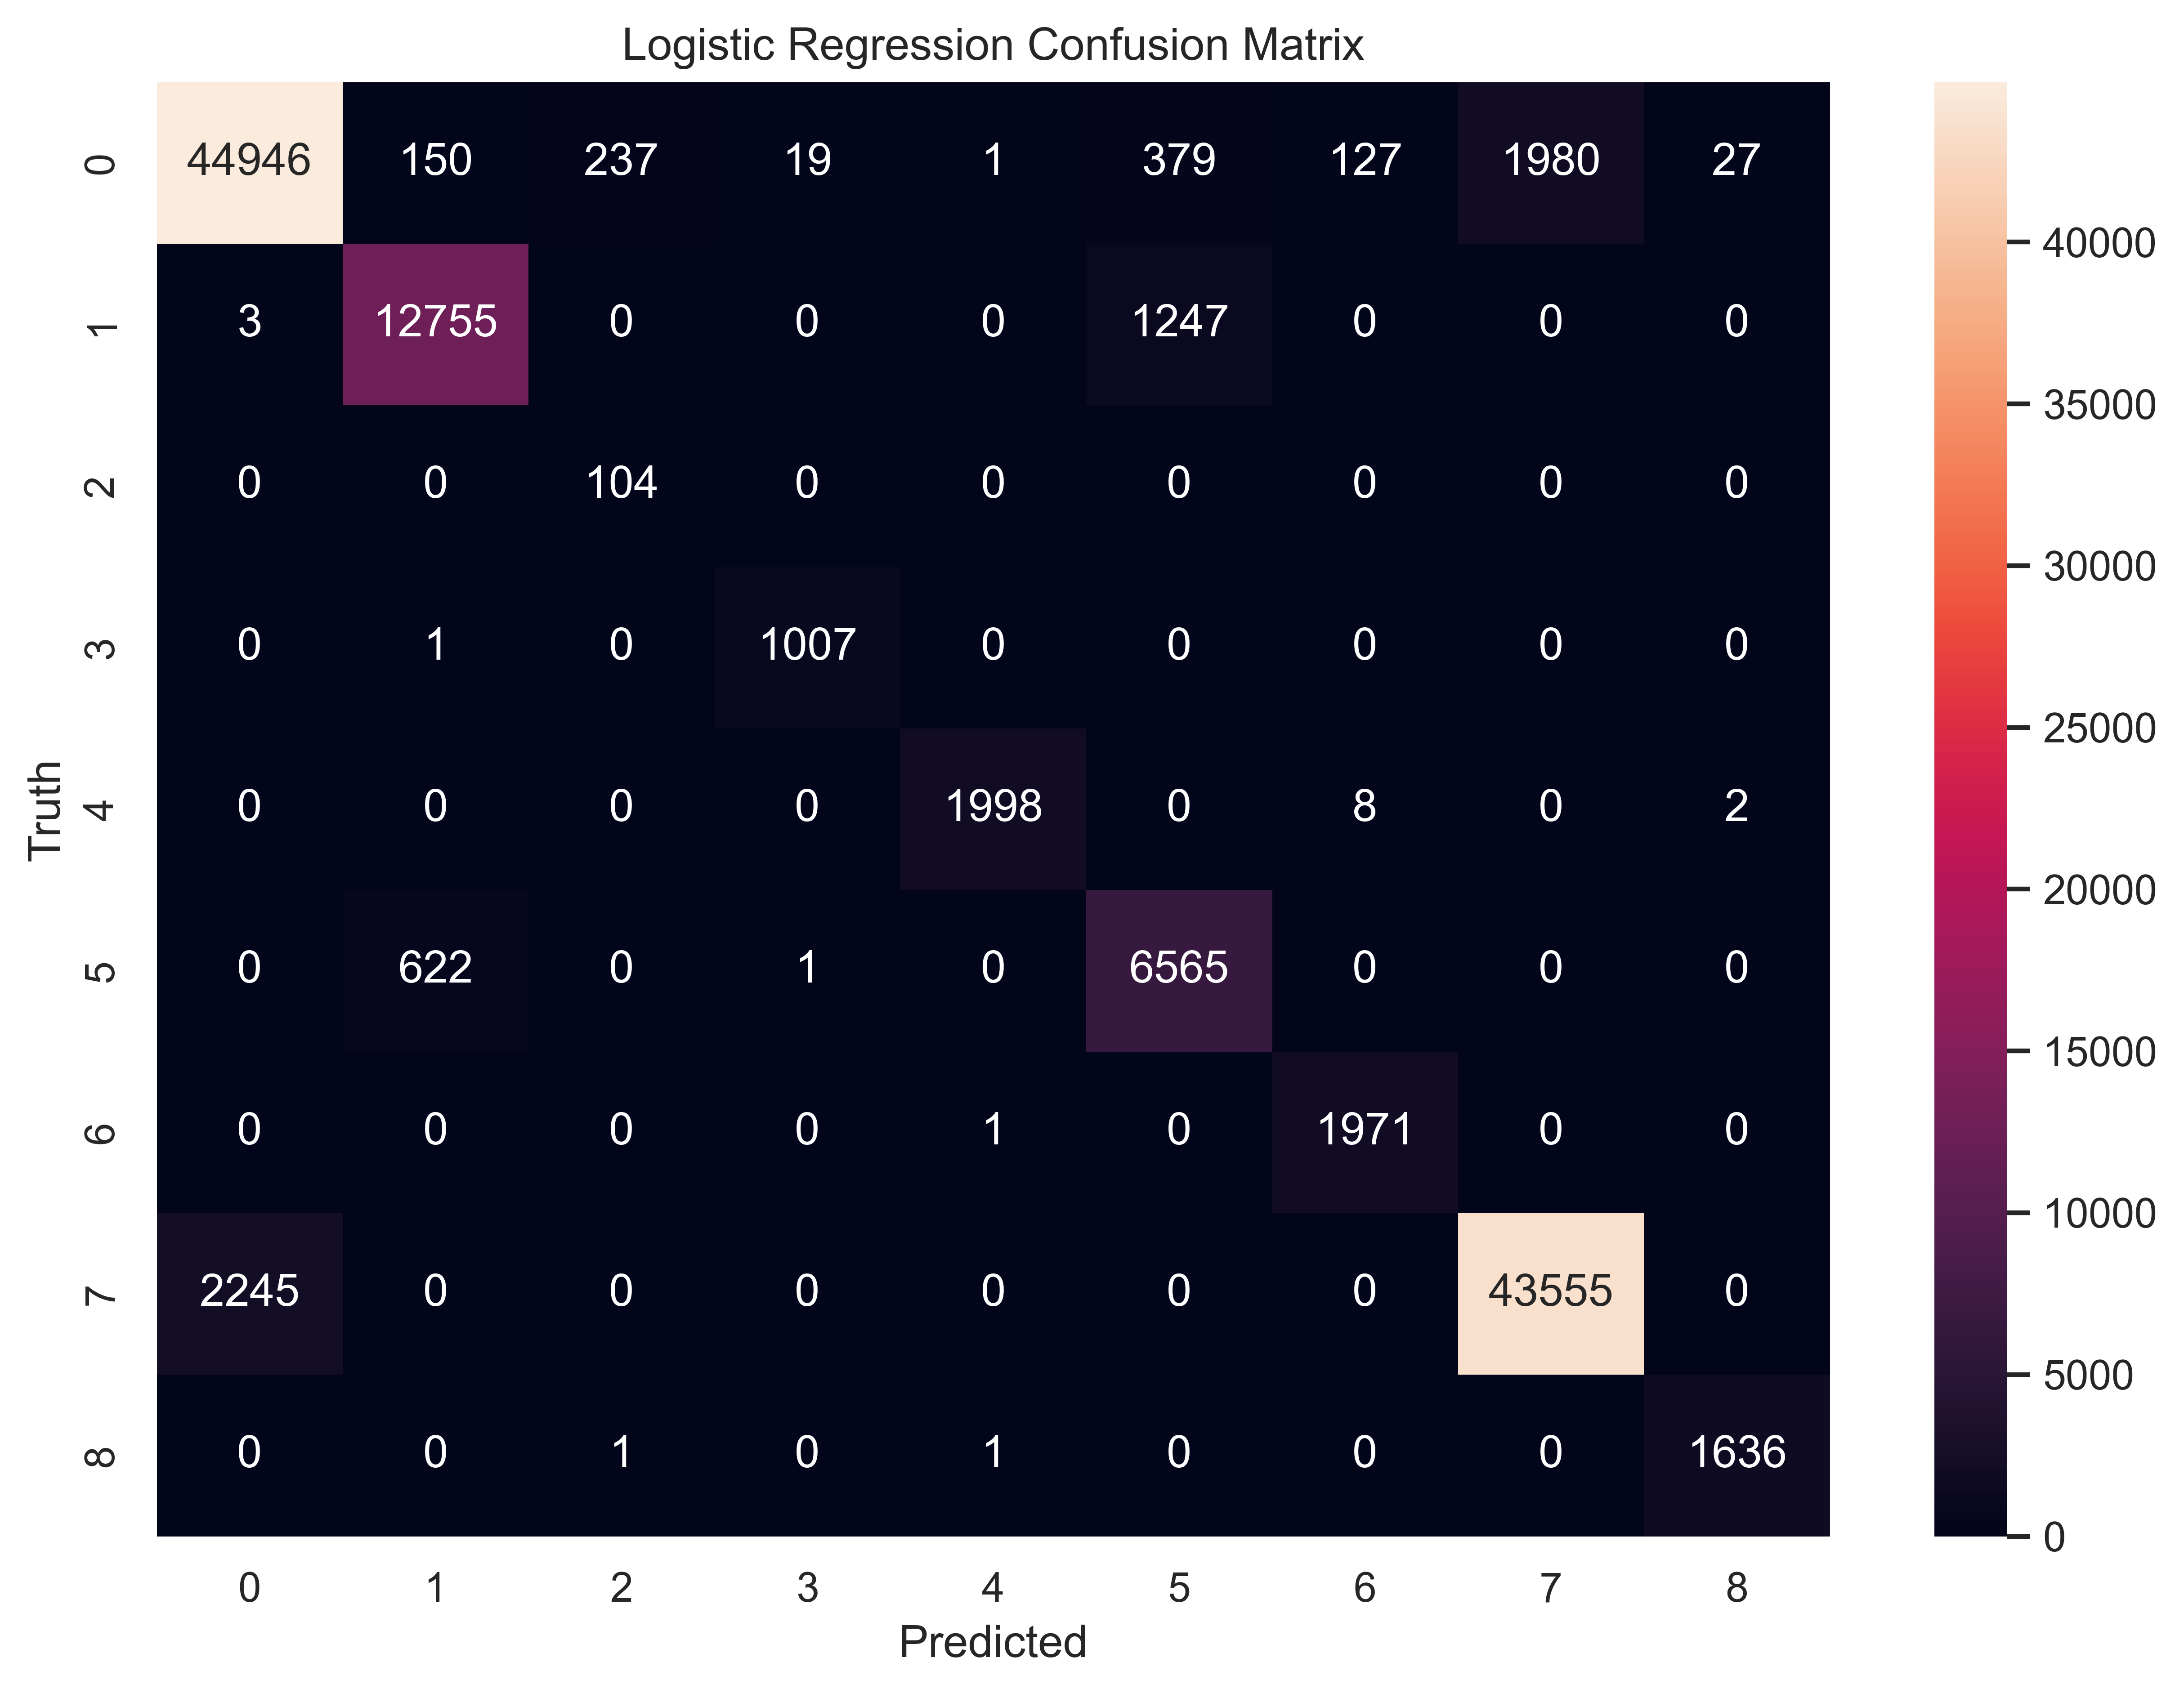

In [13]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'logistic_regression')
results_file_name = 'logistic_regression_results.txt'
cm_title = 'Logistic Regression Confusion Matrix'

print("Logistic Regression Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lr, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'logistic_regression', accuracy, precision, recall, f1, training_time, prediction_time)

## Random Forest

In [13]:
rnd_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1)
start_time = time.time()
rnd_forest.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rnd_forest.predict(X_val_scaled)
prediction_time = time.time() - start_time

# arguments for evaluation function
model_type = 'random_forest'
y_pred = y_pred_rf
results_file_name = 'random_forest_results.txt'
cm_title = 'Random Forest Confusion Matrix'

Evaluation:
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F1 Score: 0.9996
Training Time: 26.1912 seconds
Prediction Time: 0.0921 seconds
latency per sample: 0.000001 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign       1.00      1.00      1.00     47866
     HTTPFlood       1.00      1.00      1.00     14005
     ICMPFlood       1.00      1.00      1.00       104
      SYNFlood       1.00      1.00      1.00      1008
       SYNScan       1.00      1.00      1.00      2008
   SlowrateDoS       1.00      1.00      1.00      7188
TCPConnectScan       1.00      1.00      1.00      1972
      UDPFlood       1.00      1.00      1.00     45800
       UDPScan       1.00      1.00      1.00      1638

      accuracy                           1.00    121589
     macro avg       1.00      1.00      1.00    121589
  weighted avg       1.00      1.00      1.00    121589



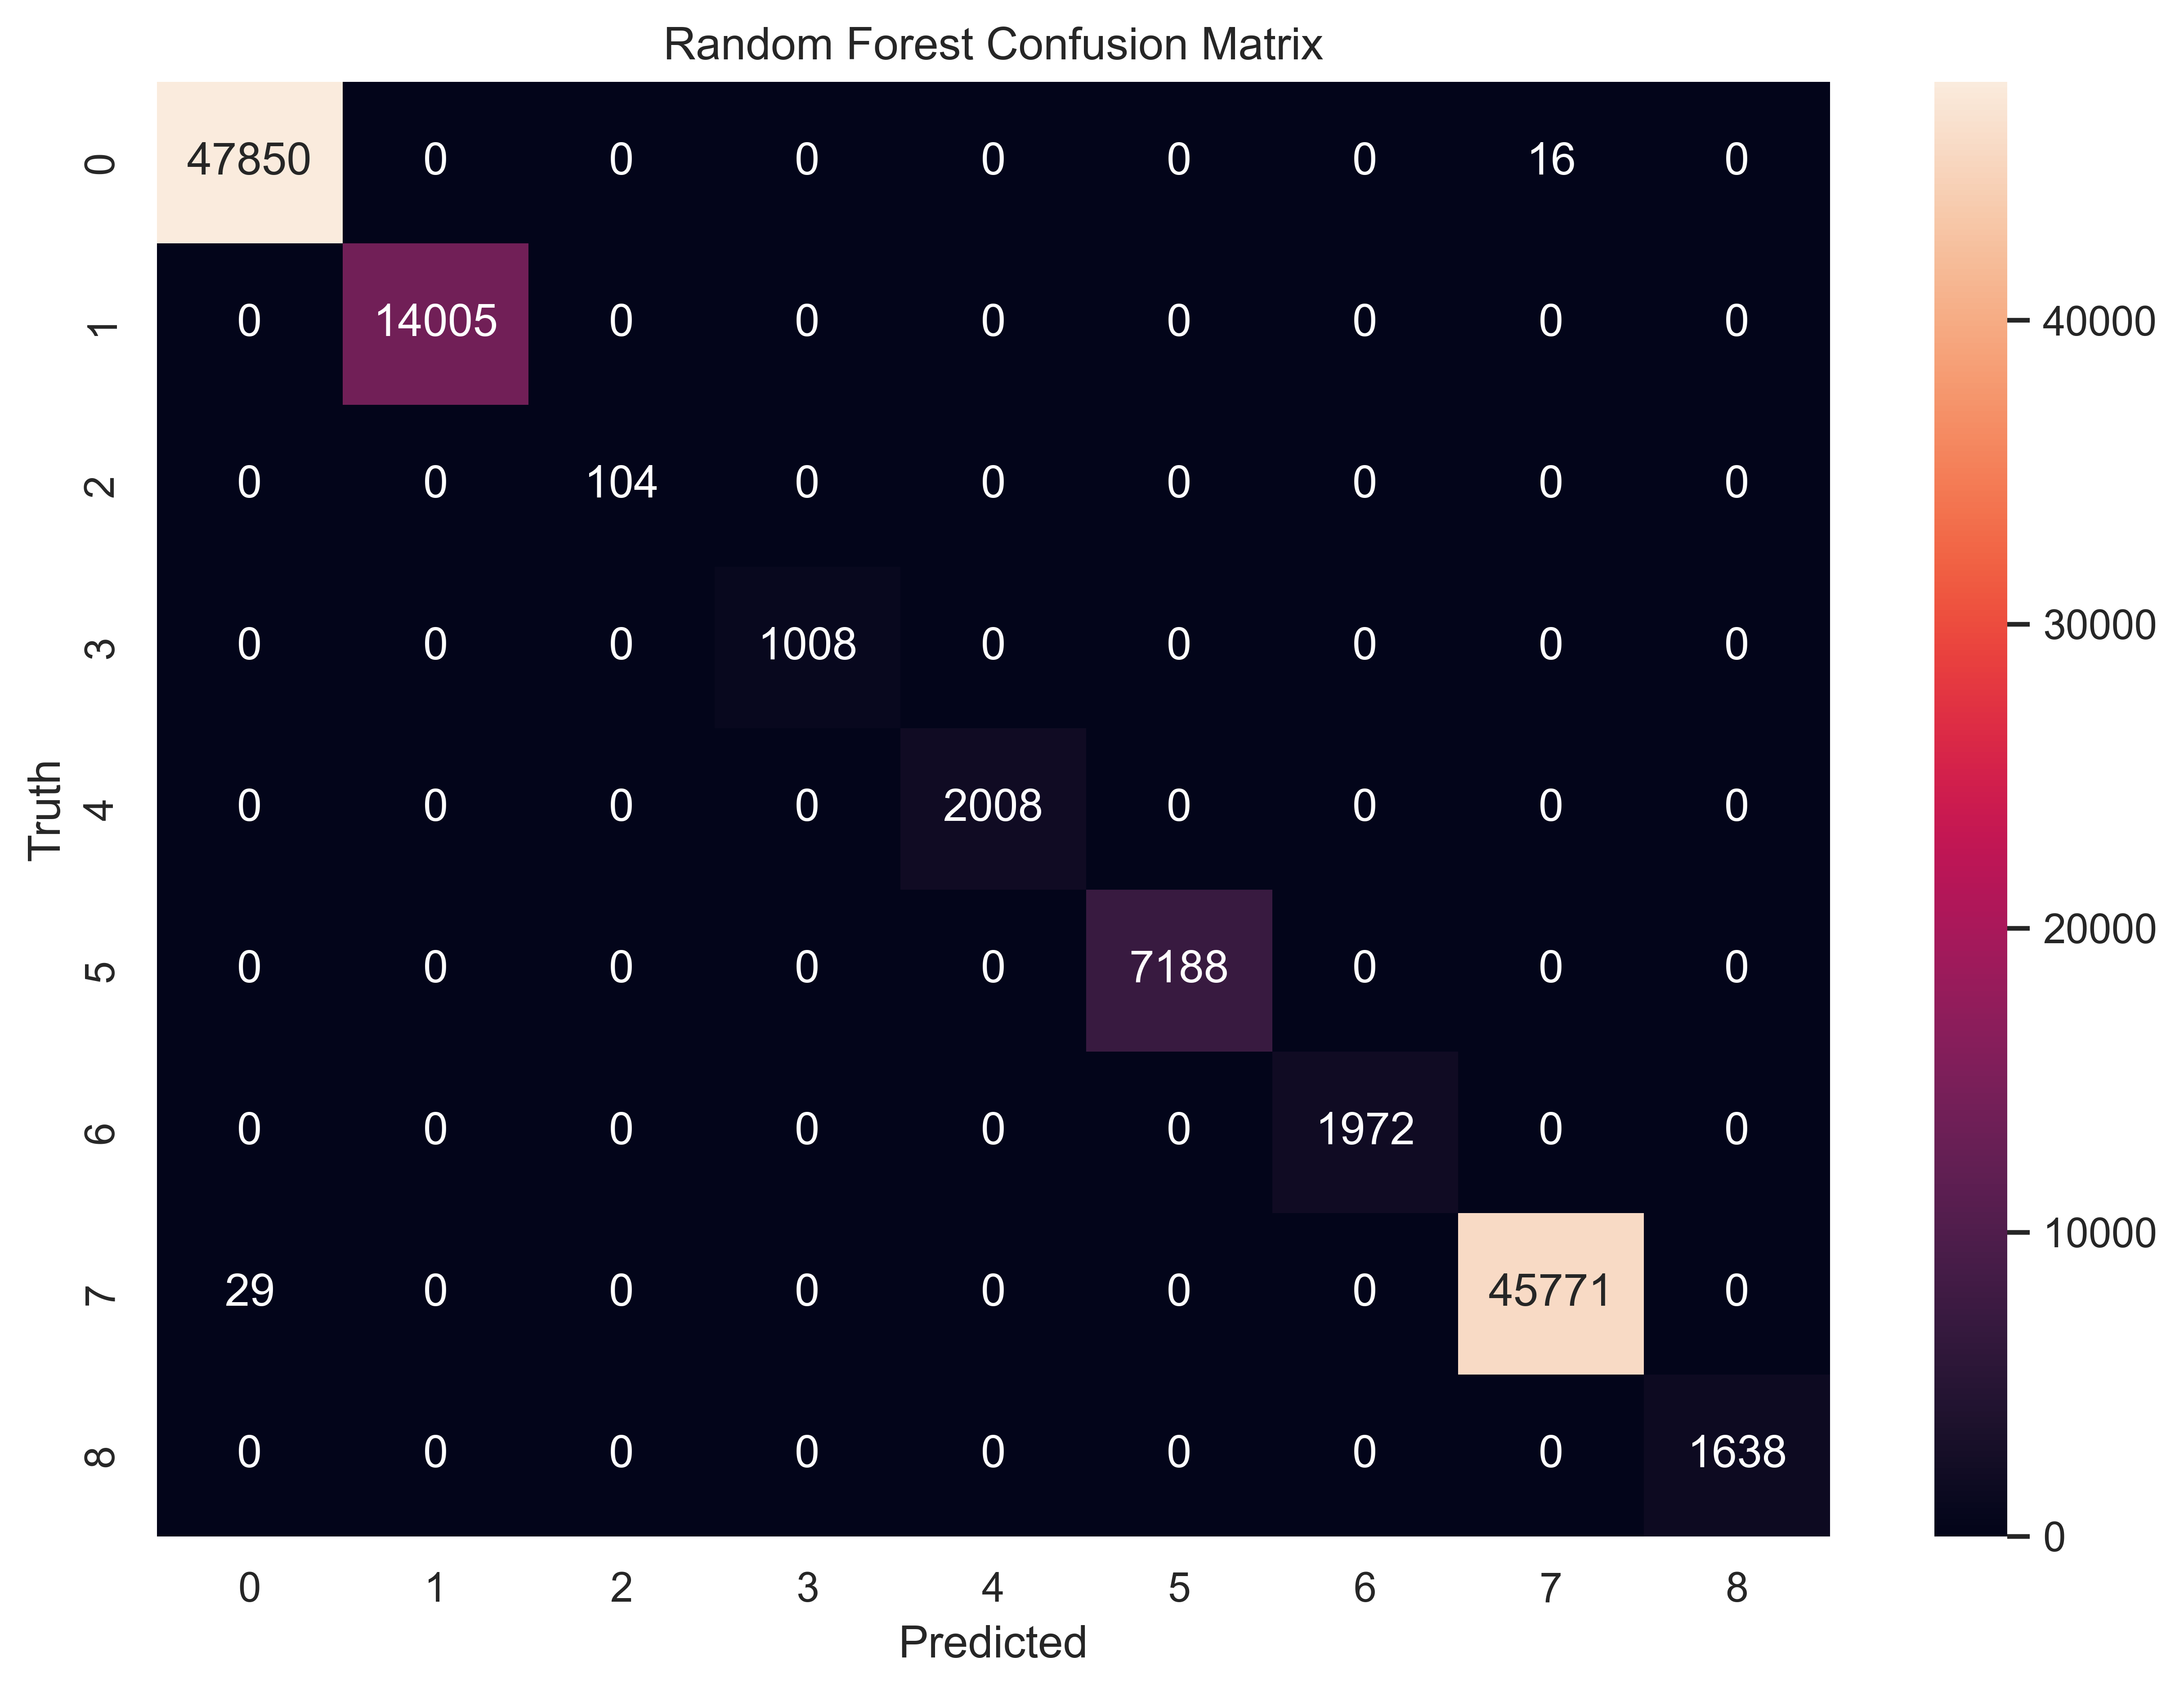

In [14]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'random_forest')
results_file_name = 'random_forest_results.txt'
cm_title = 'Random Forest Confusion Matrix'
print("Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_rf, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'random_forest', accuracy, precision, recall, f1, training_time, prediction_time)

## XGBoost

In [15]:
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(output_encoder.classes_), eval_metric='mlogloss')

# Train the model
start_time = time.time()
xgb_model.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_xgb = xgb_model.predict(X_val_scaled)
prediction_time = time.time() - start_time

XGBoost Evaluation:
Accuracy: 0.9287
Precision: 0.9331
Recall: 0.9287
F1 Score: 0.9300
Training Time: 15.4270 seconds
Prediction Time: 0.0882 seconds
latency per sample: 0.000001 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign       0.95      0.91      0.93     47866
     HTTPFlood       0.90      0.89      0.89     14005
     ICMPFlood       0.30      1.00      0.47       104
      SYNFlood       0.97      1.00      0.98      1008
       SYNScan       1.00      0.99      0.99      2008
   SlowrateDoS       0.73      0.90      0.80      7188
TCPConnectScan       0.89      1.00      0.94      1972
      UDPFlood       0.96      0.95      0.95     45800
       UDPScan       0.97      1.00      0.99      1638

      accuracy                           0.93    121589
     macro avg       0.85      0.96      0.88    121589
  weighted avg       0.93      0.93      0.93    121589



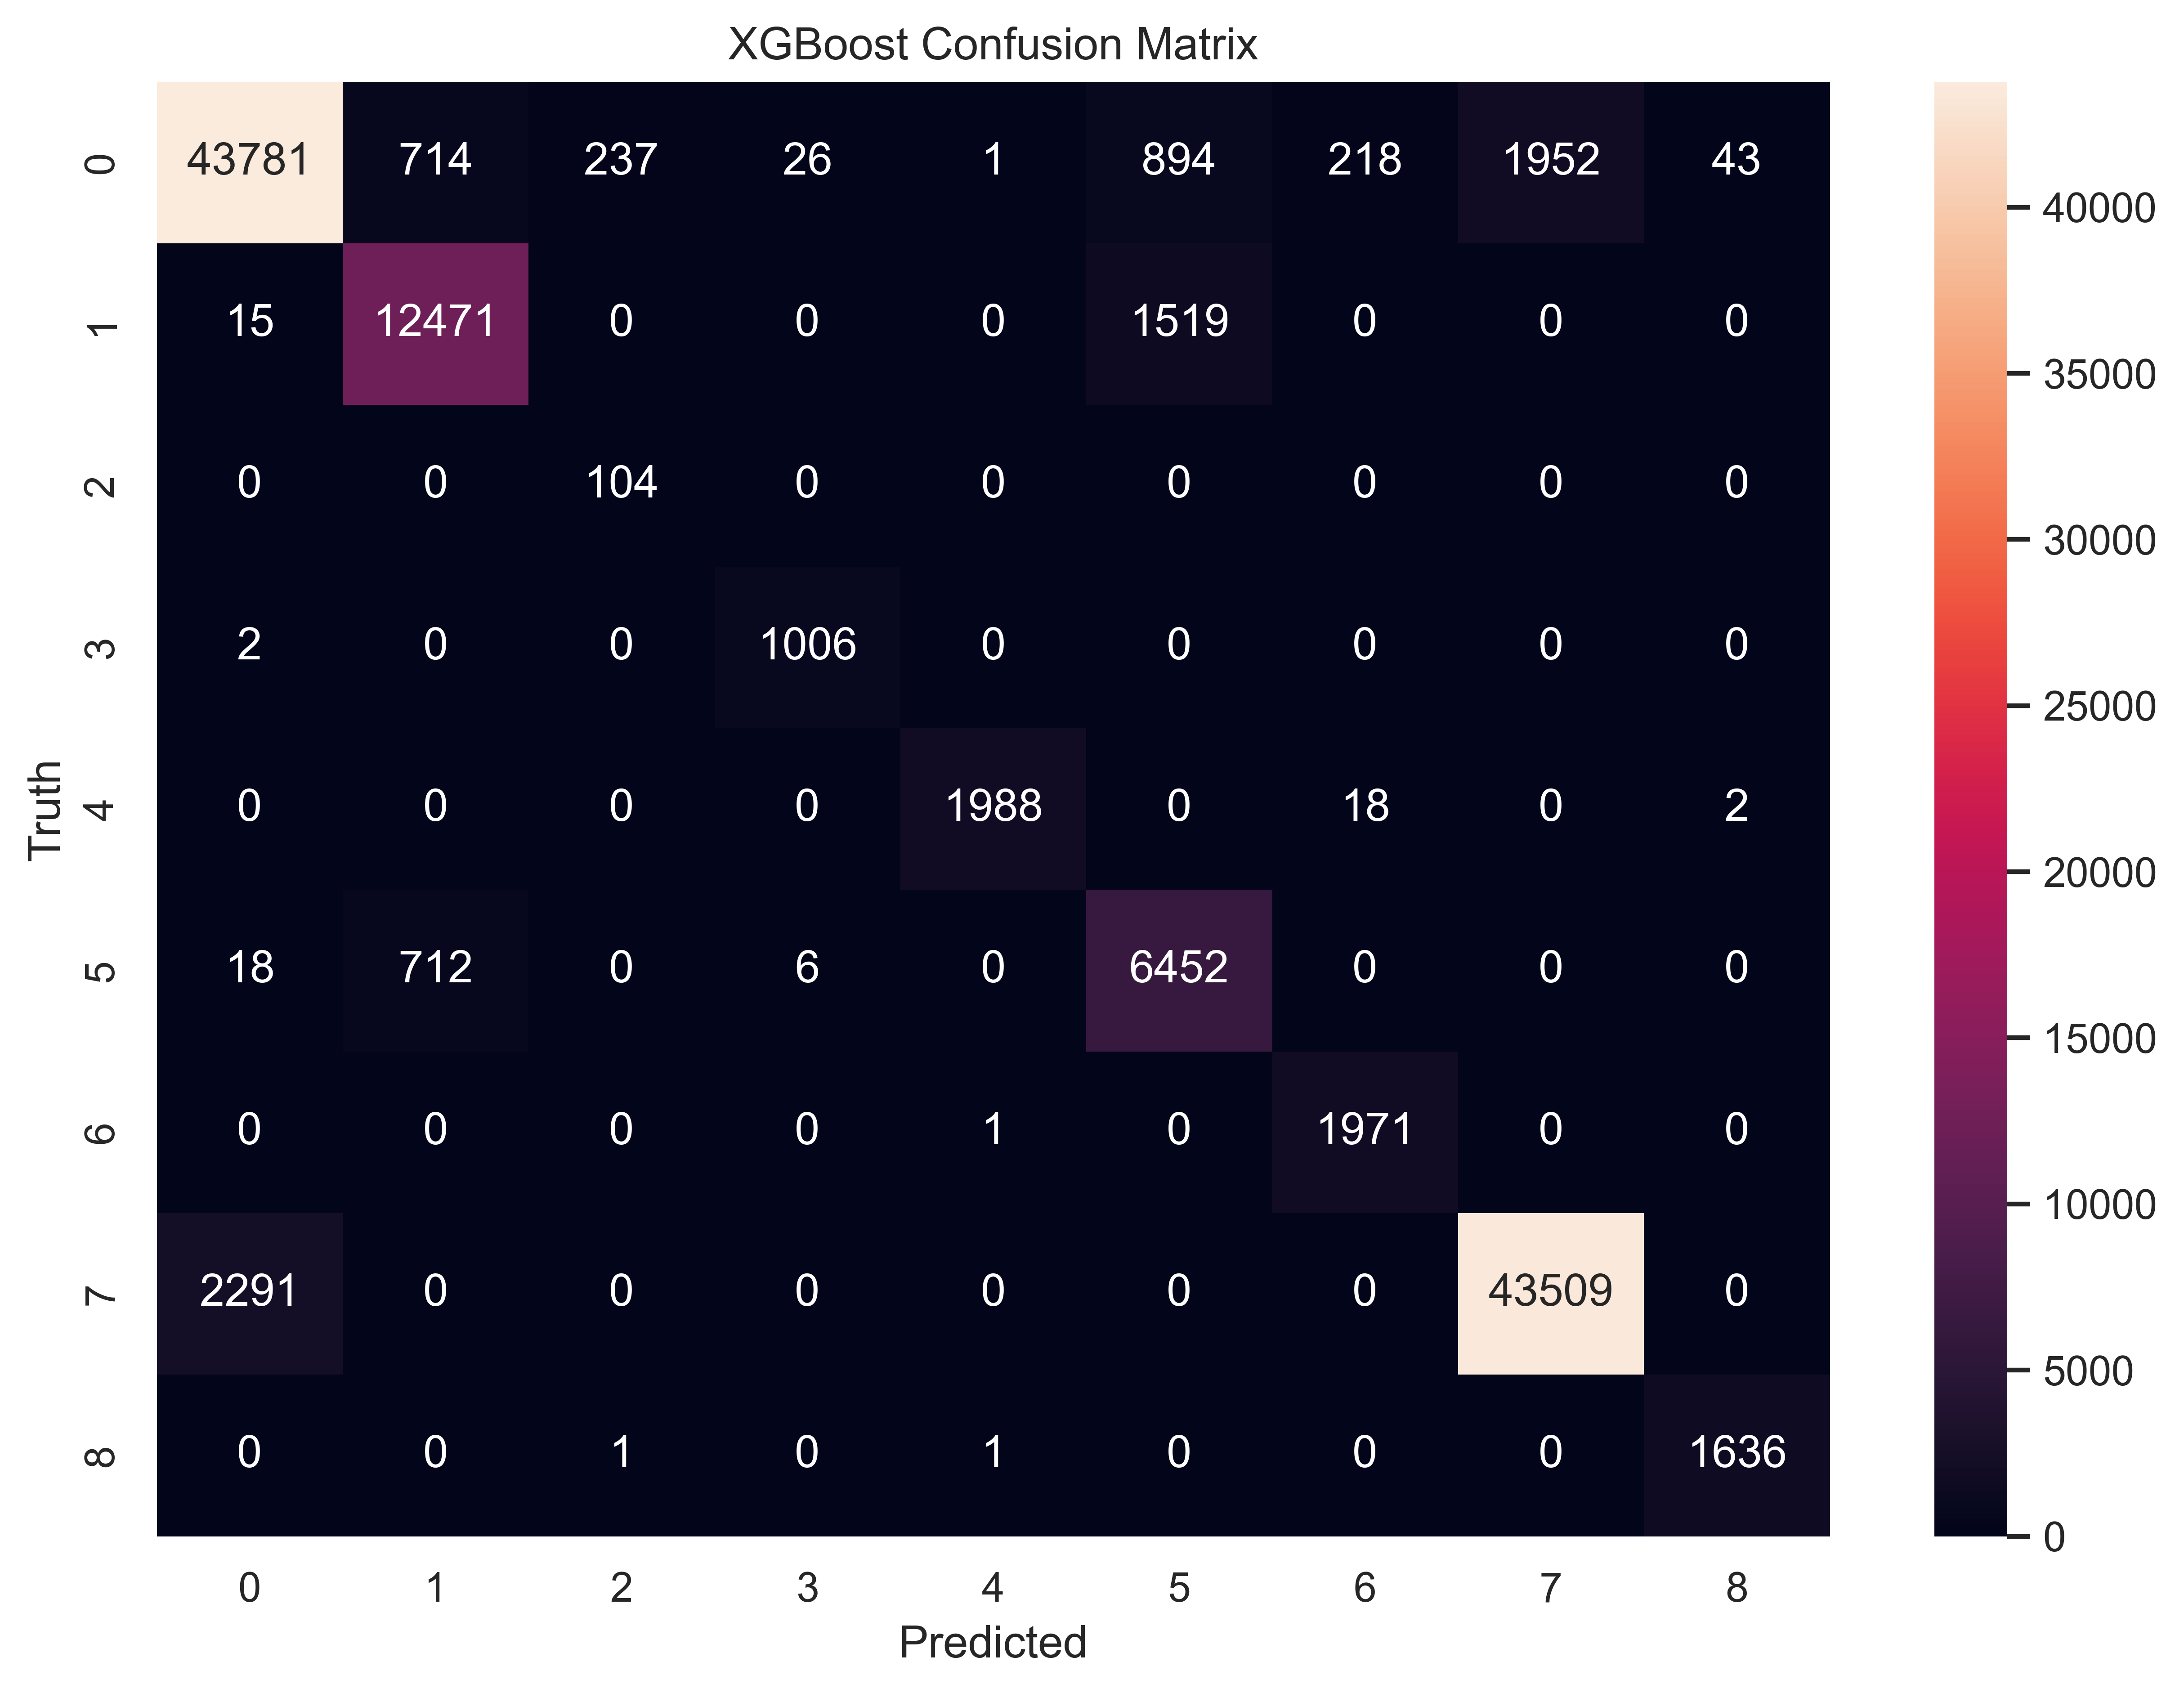

In [16]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'xgboost')
results_file_name = 'xgboost_results.txt'
cm_title = 'XGBoost Confusion Matrix'
print("XGBoost Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lr, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'xgboost', accuracy, precision, recall, f1, training_time, prediction_time)

## Naive Bayes

In [17]:
# Create a Naive Bayes classifier
nb_model = GaussianNB()

# Train the model
start_time = time.time()
nb_model.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_nb = nb_model.predict(X_val_scaled)
prediction_time = time.time() - start_time

Naive Bayes Evaluation:
Accuracy: 0.9287
Precision: 0.9331
Recall: 0.9287
F1 Score: 0.9300
Training Time: 0.2480 seconds
Prediction Time: 0.0415 seconds
latency per sample: 0.000000 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign       0.95      0.91      0.93     47866
     HTTPFlood       0.90      0.89      0.89     14005
     ICMPFlood       0.30      1.00      0.47       104
      SYNFlood       0.97      1.00      0.98      1008
       SYNScan       1.00      0.99      0.99      2008
   SlowrateDoS       0.73      0.90      0.80      7188
TCPConnectScan       0.89      1.00      0.94      1972
      UDPFlood       0.96      0.95      0.95     45800
       UDPScan       0.97      1.00      0.99      1638

      accuracy                           0.93    121589
     macro avg       0.85      0.96      0.88    121589
  weighted avg       0.93      0.93      0.93    121589



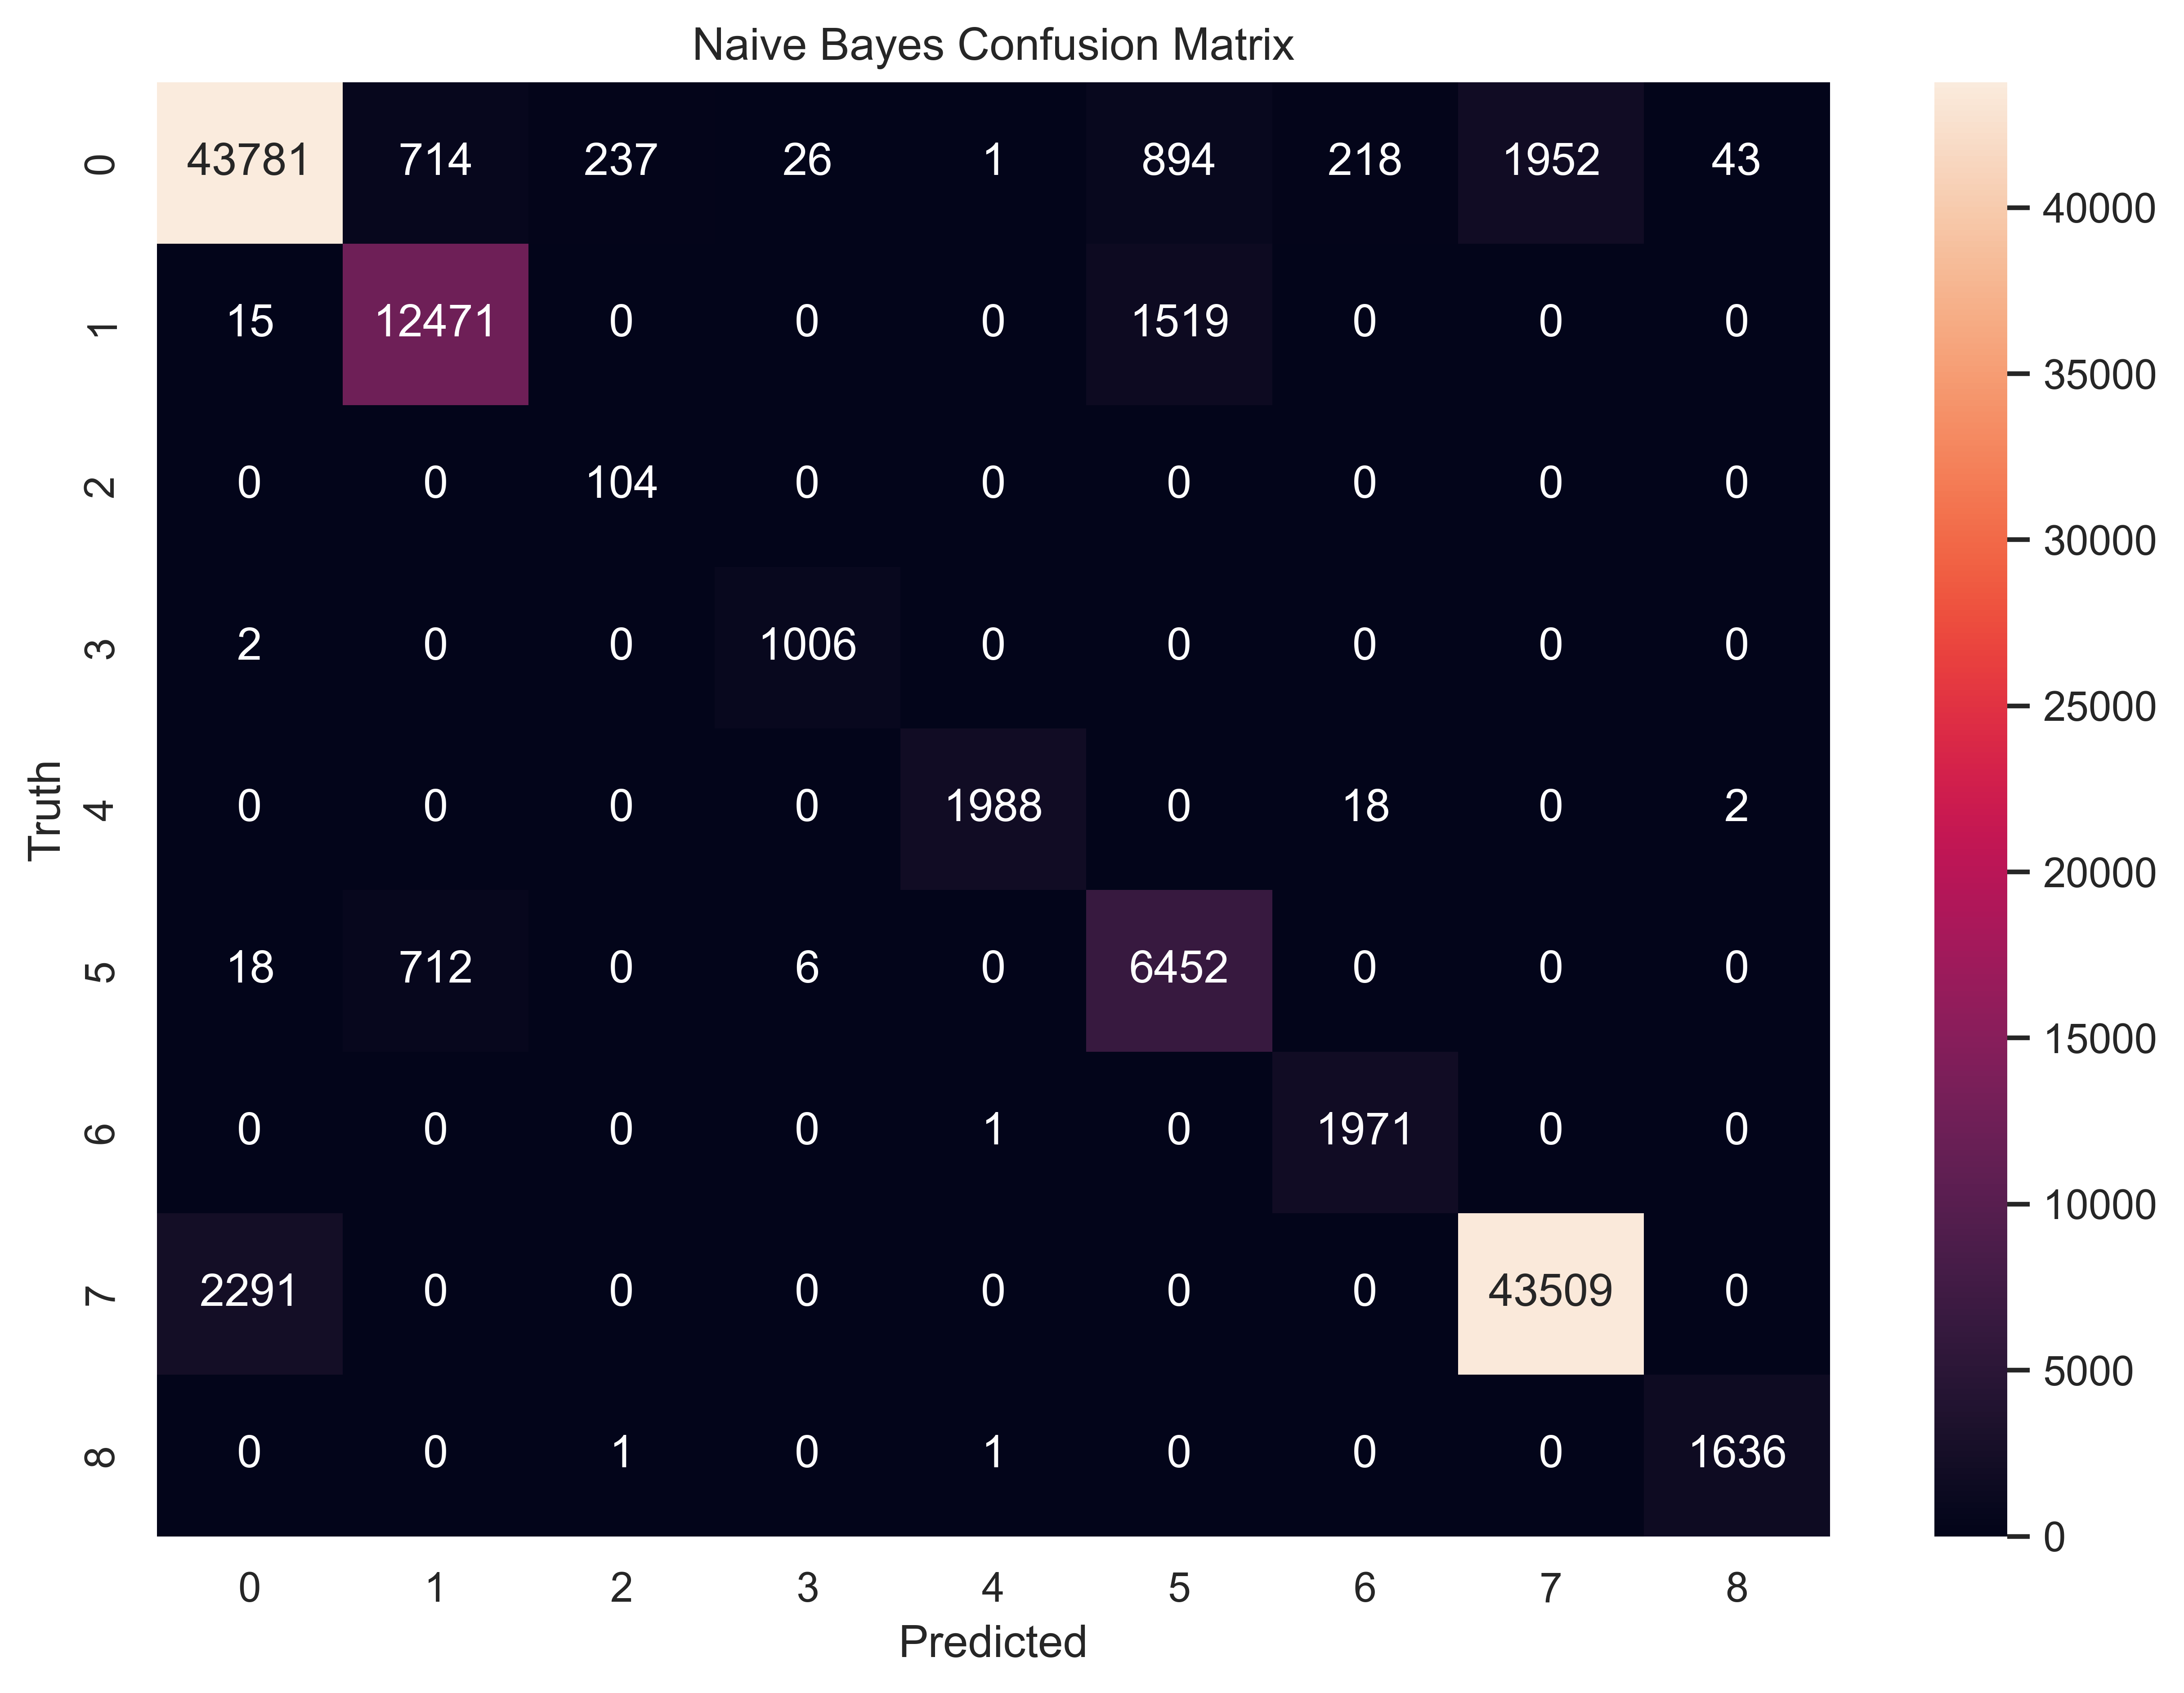

In [18]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'naive_bayes')
results_file_name = 'naive_bayes_results.txt'
cm_title = 'Naive Bayes Confusion Matrix'
print("Naive Bayes Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lr, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'naive_bayes', accuracy, precision, recall, f1, training_time, prediction_time)

## SVM

In [19]:
LSVC = LinearSVC(dual=False, random_state=42)

### Use One-vs-Rest classifier

In [20]:
ovr_classifier = OneVsRestClassifier(estimator=LSVC, n_jobs=-1)
start_time = time.time()
ovr_classifier.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

start_time = time.time()
y_pred_svm = ovr_classifier.predict(X_val_scaled)
prediction_time = time.time() - start_time

SVM Evaluation:
Accuracy: 0.9287
Precision: 0.9331
Recall: 0.9287
F1 Score: 0.9300
Training Time: 112.7681 seconds
Prediction Time: 0.0528 seconds
latency per sample: 0.000000 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign       0.95      0.91      0.93     47866
     HTTPFlood       0.90      0.89      0.89     14005
     ICMPFlood       0.30      1.00      0.47       104
      SYNFlood       0.97      1.00      0.98      1008
       SYNScan       1.00      0.99      0.99      2008
   SlowrateDoS       0.73      0.90      0.80      7188
TCPConnectScan       0.89      1.00      0.94      1972
      UDPFlood       0.96      0.95      0.95     45800
       UDPScan       0.97      1.00      0.99      1638

      accuracy                           0.93    121589
     macro avg       0.85      0.96      0.88    121589
  weighted avg       0.93      0.93      0.93    121589



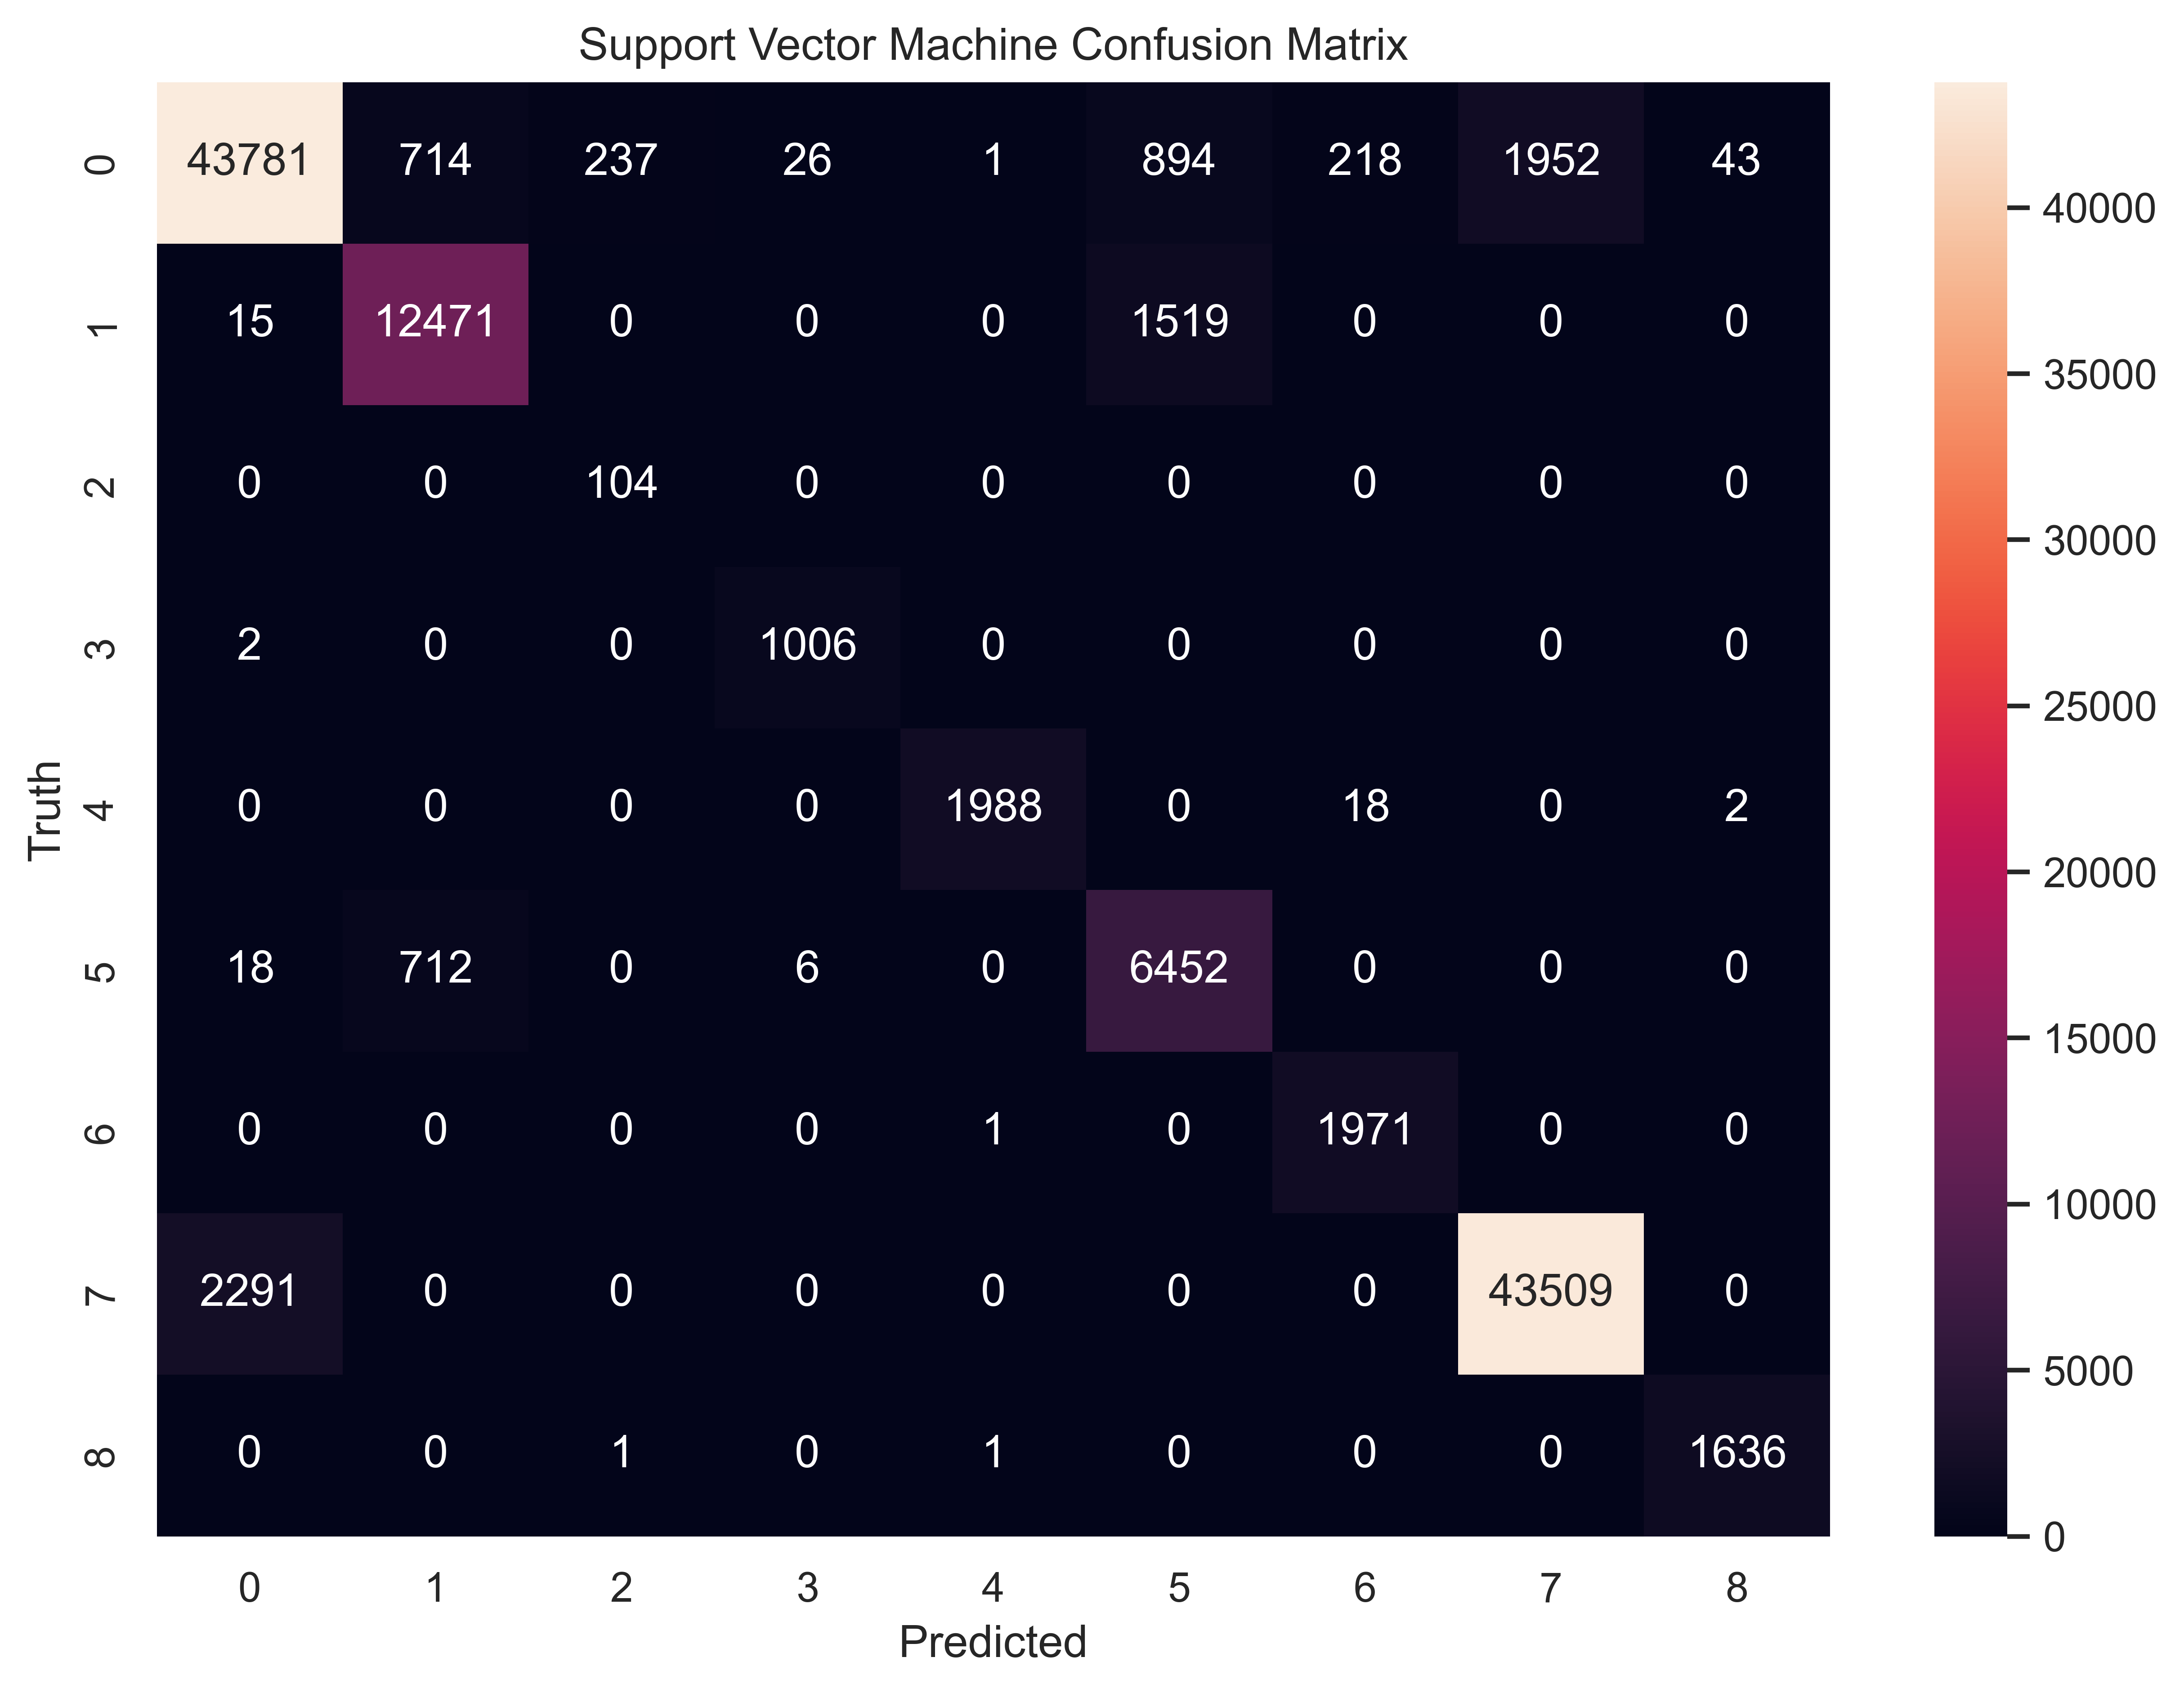

In [21]:
# arguments for evaluation function
eval_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'models', 'svm')
results_file_name = 'svm_results.txt'
cm_title = 'Support Vector Machine Confusion Matrix'
print("SVM Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lr, training_time, prediction_time, output_encoder, eval_output_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'svm', accuracy, precision, recall, f1, training_time, prediction_time)

# Bar charts

Saved v1_comparison_accuracy.png


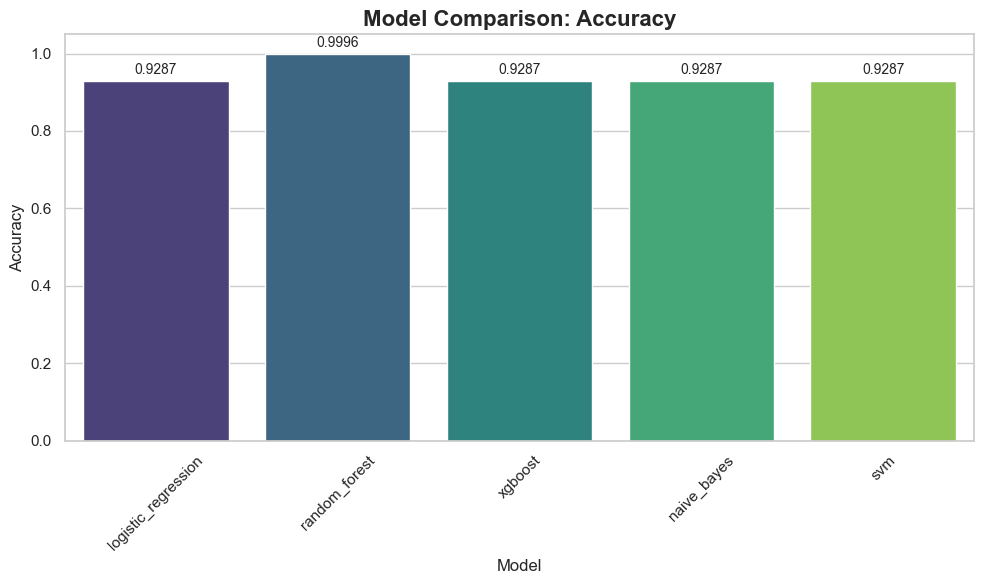

Saved v1_comparison_precision.png


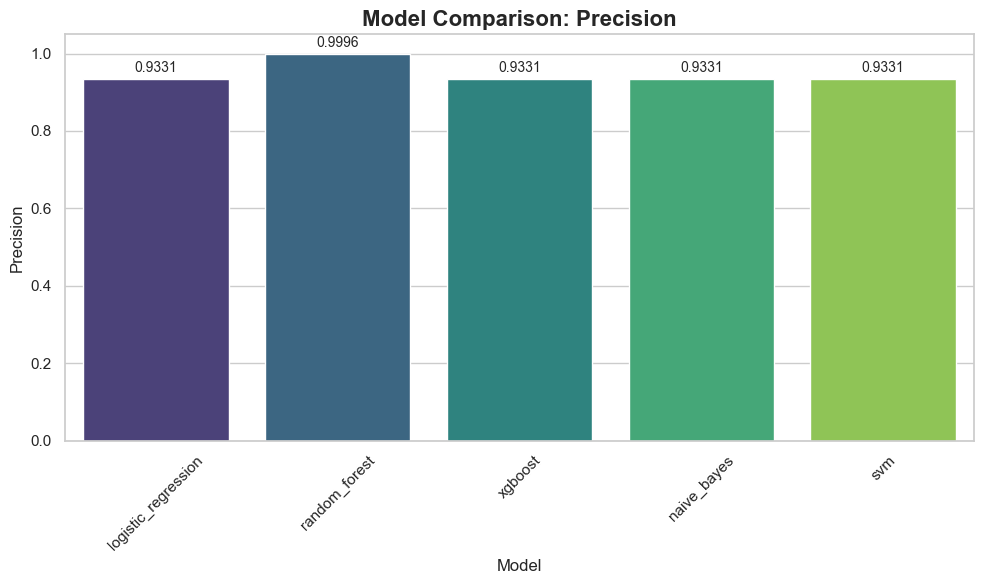

Saved v1_comparison_recall.png


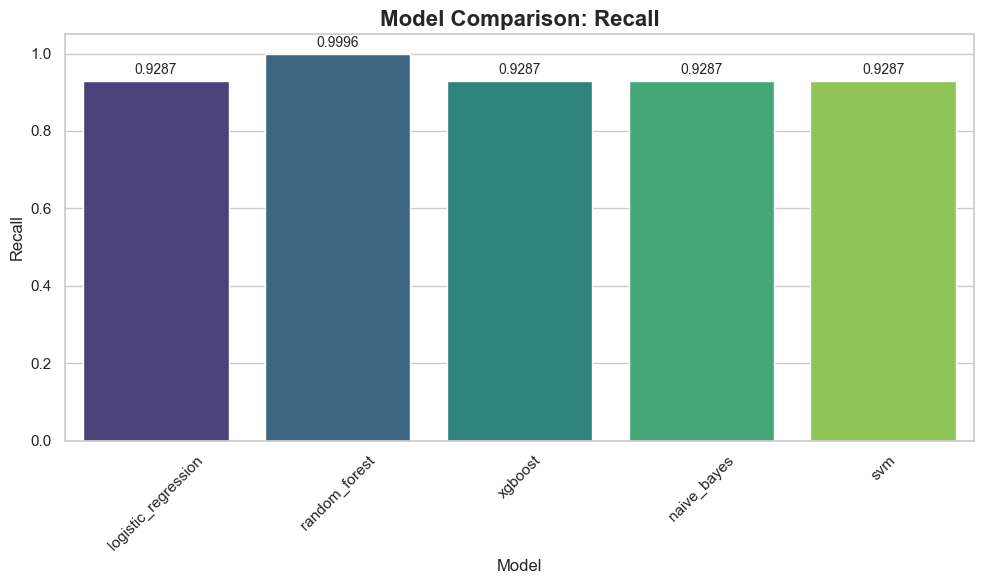

Saved v1_comparison_f1-score.png


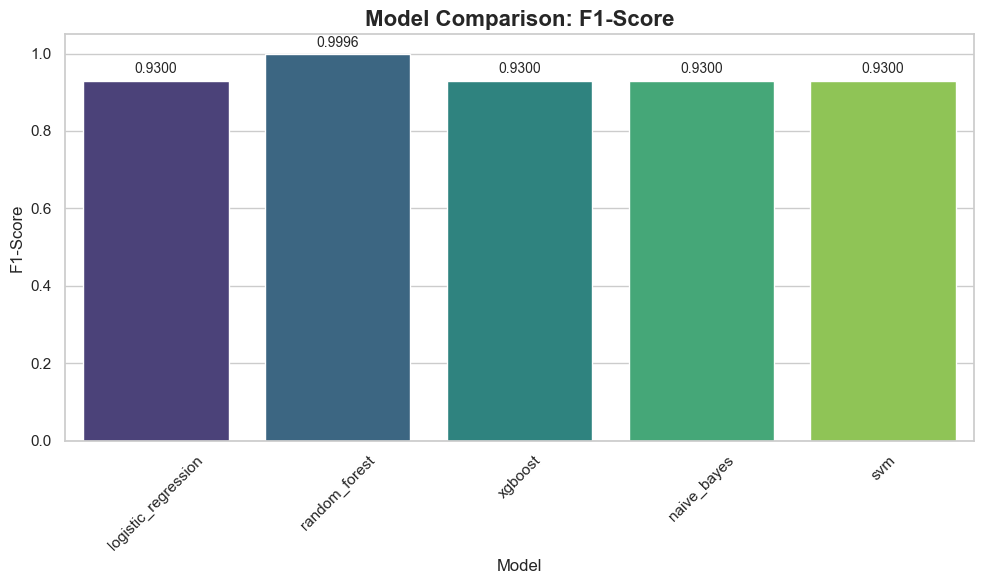

Saved v1_comparison_training_time_s.png


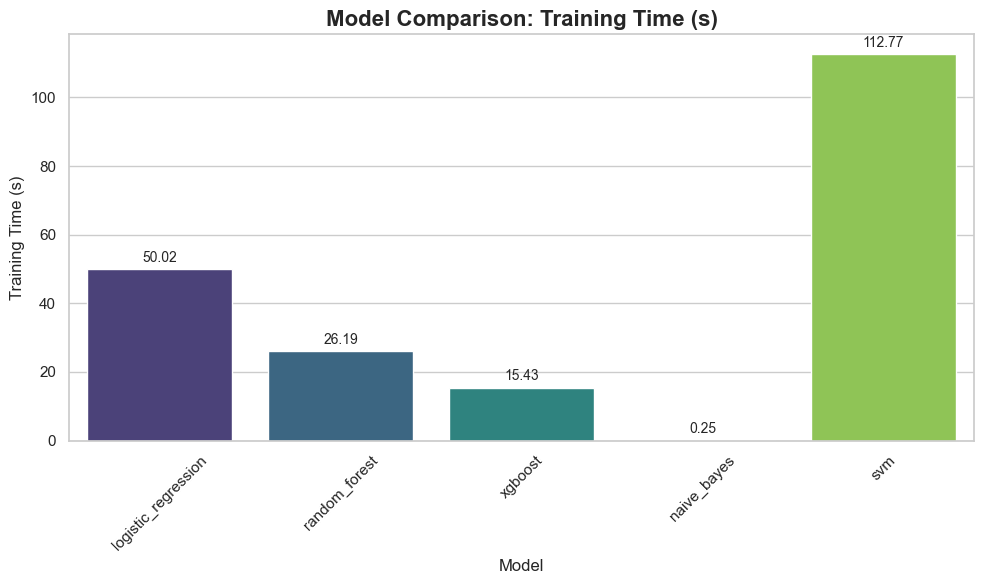

Saved v1_comparison_prediction_time_s.png


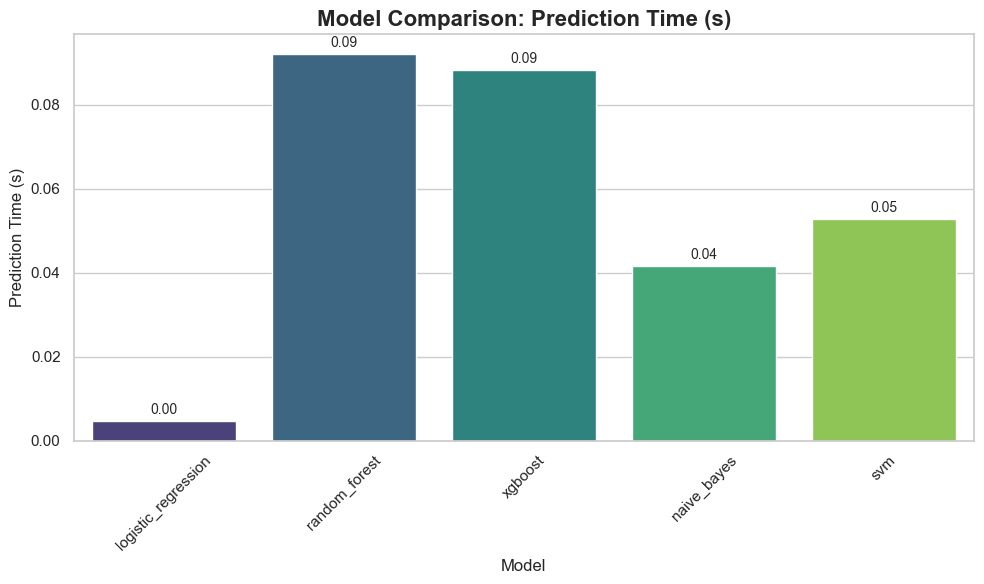

In [23]:
machine_learning_output_dir = os.path.join('data', 'figures', '5G NIDD', 'machine learning', 'bar charts')
plot_individual_metrics(model_results, machine_learning_output_dir, version)